In [1]:
from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from collections import OrderedDict

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.layers import LaterallyConnectedLayer, LaterallyConnectedLayer2, LaterallyConnectedLayer3
from lateral_connections.torch_utils import *
from lateral_connections.dataset import TinyDataset, TinyDatasetEasy

import wandb
import datetime

config = {
    'num_classes': 10,
    'learning_rate': 3e-4,
    'num_multiplex': 2,
    'batch_size': 4,
    'num_epochs': 20,
    'lcl_alpha': 0.1,
    'lcl_eta': 0.0, # Empirically evaluated :eta to switch ~30 from-to connections (0.0360: 40, 0.0160: 30, 0.0030: 10, 0.0015: 5)
    'lcl_theta': 0.2,
    'lcl_iota': 0.2,
    'lcl_distance': 3,
    'conv_size': 10,
    'use_scaling': False,
}

lcl = LaterallyConnectedLayer3(config['num_multiplex'], config['conv_size'], 14, 14,
                              d=config['lcl_distance'],
                              prd=config['lcl_distance'],
                              disabled=False,
                              alpha=config['lcl_alpha'],
                              beta=(1 / ((50000/2) / config['batch_size'])),
                              eta=config['lcl_eta'],
                              theta=config['lcl_theta'],
                              iota=config['lcl_iota'],
                              use_scaling=config['use_scaling'],
                              random_k_change=False,
                              random_multiplex_selection=False,
                              gradient_learn_k=False)
lcl.to(lcl.device)
lcl.device

lcl.K -= 0.5 * lcl.K

In [13]:
def plot_kernels(K, plot_scale=3):
    num_kernels = K.shape[0]

    fig, axs = plt.subplots(num_kernels, num_kernels, figsize=(plot_scale*num_kernels, plot_scale*num_kernels))

    kernel_data = K.cpu()

    for x in range(num_kernels):
        for y in range(num_kernels):
            axs[x,y].imshow(kernel_data[x,y,...])
            
    plt.show()
    plt.close()
    
def plot_images(x, plot_scale=3, vmax=None):
    fig, axs = plt.subplots(1, x.shape[1], figsize=(plot_scale*x.shape[1], plot_scale))
    
    for i in range(x.shape[1]):
        if vmax is None:
            axs[i].imshow(x[0,i,...])
        else:
            axs[i].imshow(x[0,i,...], vmax=vmax)
        axs[i].set_title(f"Image #{i}")
    plt.show()
    
def plot_impact(x):
    plt.imshow(x[0].cpu())
    plt.ylabel('Source FM')
    plt.xlabel('Target FM')
    plt.show()

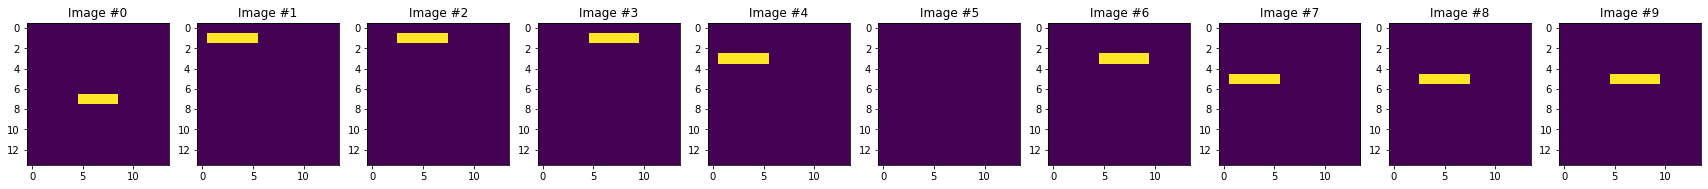

torch.Size([1, 10, 14, 14])

In [14]:
images = 0 * torch.ones((1, 10, 14, 14))
#images[0, 0, 7, 7] = 1
images[0, 0, 7, 5:9] = 1

for x in range(3):
    for y in range(3):
        i = 3*x+y+1
        xdiff = 2*x-2
        ydiff = 2*y-2
        #images[:, i, 7+xdiff, 7+ydiff] = 1
        images[:, i, 3+xdiff, 3+ydiff:8+ydiff] = 1
        
#images[0, 5] = 0.2 * torch.normal(torch.zeros(images[0, 5].shape), torch.ones(images[0, 5].shape))
images[0, 5] = 0

plot_images(images, vmax=1)
images.shape

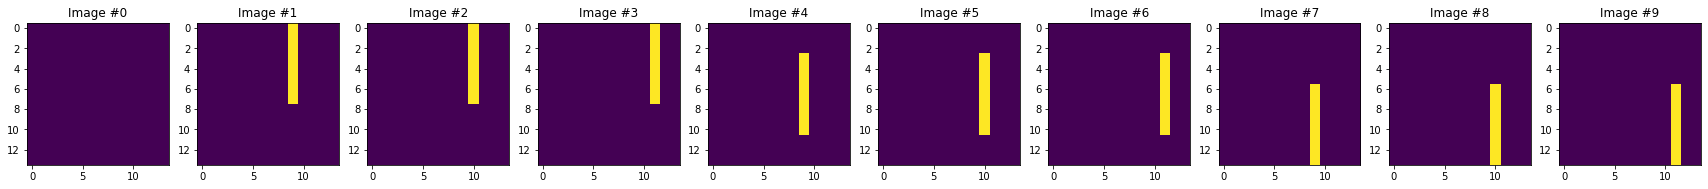

torch.Size([1, 10, 14, 14])

In [15]:
images2 = 0 * torch.ones((1, 10, 14, 14))

for x in range(3):
    for y in range(3):
        i = 3*x+y+1
        xdiff = 3*x-3
        ydiff = 1*y-1
        images2[:, i, 3+xdiff:11+xdiff, 10+ydiff] = 1
        
#images2[0, 0] = 0.2 * torch.normal(torch.zeros(images2[0, 0].shape), torch.ones(images2[0, 0].shape))
images2[0, 0] = 0

plot_images(images2, vmax=1)
images2.shape

In [16]:
def do_kernel_update(A, selected_multiplex_mask):
    # Lateral Connection Reinforcement
    K_change = torch.zeros(size=lcl.K.shape, device=lcl.device)

    # Iterate through the different necessary shifts between the feature maps
    # to account for all positions in the kernel K
    #
    for x in range(lcl.K.shape[-2]):
        for y in range(lcl.K.shape[-1]):
            # source and target feature maps are transposed to enable broadcasting across
            # the batch size dimension
            #
            xoff_f = - lcl.d + x
            yoff_f = - lcl.d + y
            source_fms = A[:, :, max(0,xoff_f):A.shape[-2]+min(xoff_f,0), max(0,yoff_f):A.shape[-1]+min(0,yoff_f)]
            source_fms = source_fms.transpose(0,1)

            xoff_i = lcl.d - x
            yoff_i = lcl.d - y
            target_fms = A[:, :, max(0,xoff_i):A.shape[-2]+min(xoff_i,0), max(0,yoff_i):A.shape[-1]+min(0,yoff_i)]
            target_fms = target_fms.transpose(0,1).unsqueeze(1)

            # calculate the product of all feature maps (source) together with the
            # to-be-influenced feature map (target) efficiently
            #
            # Initially, self.A contains [batch_size, num_fm, fm_height, fm_width] dimensions
            #
            # Designations of einsum characters:
            #   a:  Extra dim to ensure each FM in target is multipled with the whole source blob
            #   b:  Feature Map #
            #   c:  Batch (see the transpose(0,1) calls)
            #   d:  Feature Map Height
            #   e:  Feature Map Width
            #
            tmp = torch.einsum('abcde,bcde->cab', target_fms, source_fms)
            
            # inhibit inactive multiplex cell changes
            #
            tmp *= selected_multiplex_mask[:,:,:,0,0]

            # inhibit multiplex repetitions
            #
            diagonal_repetition_mask = 1 - torch.eye(lcl.num_fm.item(), device=lcl.device).repeat(lcl.n, lcl.n)
            diagonal_repetition_mask += torch.eye(int(lcl.num_fm*lcl.n), device=lcl.device)
            tmp *= diagonal_repetition_mask.unsqueeze(0)

            # Average across the batch size
            #
            number_of_samples_per_pixel = torch.count_nonzero(tmp, dim=0)
            number_of_samples_per_pixel[torch.where(number_of_samples_per_pixel == 0)] = 1
            K_change[:, :, x, y] = torch.sum(tmp, dim=0) / number_of_samples_per_pixel

    abs_sum = torch.sum(torch.abs(K_change), dim=(-2,-1))
    changing_kernels = abs_sum.to(torch.bool).to(torch.long).unsqueeze(-1).unsqueeze(-1)
    unchanged_kernels = 1 - changing_kernels

    lcl.K *= (1 - lcl.alpha) * changing_kernels + unchanged_kernels
    lcl.K += lcl.alpha * K_change
    
    """
    fig,axs = plt.subplots(K_change.shape[0], K_change.shape[1], figsize=(3*K_change.shape[1], 3*K_change.shape[0]))
    for x in range(K_change.shape[0]):
        for y in range(K_change.shape[1]):
            if impact_small[0,x,y] > 0:
                axs[y,x].imshow(K_change[x,y,...].cpu())
            else:
                axs[y,x].axis('off')
    plt.show()
    """
    
    return tmp
    
def do_round(images, debug=False):
    A_raw = images.reshape((1,10,14,14))
    A_raw = A_raw.to(lcl.device)

    batch_size = A_raw.shape[0]

    A = A_raw.repeat(1, config['num_multiplex'], 1, 1)
    padded_A = lcl.pad_activations(A)

    impact = []
    for idx in range(padded_A.shape[1]):
        kernel = lcl.K[:, idx, ...].unsqueeze(1)
        lateral_impact = F.conv2d(padded_A, kernel, groups=int(lcl.n*lcl.num_fm), padding=0)

        impact.append(torch.sum(lateral_impact.unsqueeze(2), dim=(-2,-1)))

    impact = torch.cat(impact, dim=2)

    impact -= impact.min()
    if impact.max != 0:
        impact /= impact.max()

    impact_p1 = torch.clone(impact)
    if debug:
        print(impact_p1)
    
    # -----

    eta = 0.036
    impact += eta * torch.normal(torch.zeros(impact.shape), torch.ones(impact.shape)).to(lcl.device)
    impact_p2 = torch.clone(impact)

    # -----

    diagonal_repetition_mask = 1 - torch.eye(lcl.num_fm.item(), device=lcl.device).repeat(lcl.n, lcl.n)
    impact *= diagonal_repetition_mask.unsqueeze(0)
    impact_p3 = torch.clone(impact)

    # -----

    impact_reshaped = impact.reshape((batch_size, lcl.n, lcl.num_fm, lcl.n * lcl.num_fm))

    idx = torch.argmax(impact_reshaped, dim=1, keepdims=True)
    active_multiplex_mask = torch.zeros_like(impact_reshaped).scatter_(1, idx, 1.)
    active_multiplex_mask = active_multiplex_mask.reshape((batch_size, lcl.n*lcl.num_fm, lcl.n*lcl.num_fm))

    impact *= active_multiplex_mask
    impact_p4 = torch.clone(impact)

    # -----

    th = float(1 - (0.75 / lcl.n)) # (1 - top%/n)
    impact_threshold = torch.quantile(impact.reshape((impact.shape[0], impact.shape[1]*impact.shape[2])), th, dim=1)
    #impact_threshold = torch.quantile(impact.reshape((impact.shape[0], impact.shape[1]*impact.shape[2])), 0.8, dim=1)
    indices = torch.where(impact >= impact_threshold.unsqueeze(-1).unsqueeze(-1))



    large_K = lcl.K.repeat(batch_size, 1, 1, 1, 1)
    selected_multiplex_mask = torch.zeros(large_K.shape, device=lcl.device, dtype=torch.bool)
    selected_multiplex_mask[indices] = 1.0

    impact_small = torch.zeros(impact.shape)
    impact_small[indices] = 1

    # -----
    
    fig, axs = plt.subplots(1, 5, figsize=(3*5, 3))
    fig.suptitle('Multiplex Selection ("Impact")')
    axs[0].imshow(impact_p1[0].cpu())
    axs[1].imshow(impact_p2[0].cpu())
    axs[2].imshow(impact_p3[0].cpu())
    axs[3].imshow(impact_p4[0].cpu())
    axs[4].imshow(impact_small[0].cpu())
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # -----
    
    padded_A = lcl.pad_activations(torch.clone(A_raw.repeat(1, lcl.n, 1, 1)))

    large_K = lcl.K.repeat(batch_size, 1, 1, 1, 1)
    large_K *= selected_multiplex_mask

    L = torch.zeros((batch_size, lcl.n*lcl.num_fm, lcl.fm_height, lcl.fm_width), device=lcl.device)

    for b in range(batch_size):
        L[b, ...] = F.conv2d(padded_A[b, ...].unsqueeze(0), minmax_on_fm(large_K[b,...]), padding=0) / lcl.num_fm
        #L[b, ...] = F.conv2d(padded_A[b, ...].unsqueeze(0), minmax_on_fm(large_K[b,...].transpose(0,1)), padding=0) / lcl.num_fm

    output = torch.sum(L.reshape((batch_size, lcl.n, lcl.num_fm, L.shape[-2], L.shape[-1])), dim=1)
    plot_images(output.cpu())
    
    """
    print('Feature Map Input')
    plot_images(images)
    print('LCL Output')
    plot_images(output.reshape((10,1,14,14)).cpu())
    print('Feature Map Input + LCL Output')
    plot_images(0.5*images + 0.5*output.reshape((10,1,14,14)).cpu())
    """
    
    # -----
    
    tmp = do_kernel_update(A, selected_multiplex_mask)
    return tmp

tensor([[[0.7182, 0.6120, 0.6793, 0.6481, 0.6768, 0.6462, 0.7016, 0.6141,
          0.6476, 0.5976, 0.6451, 0.6425, 0.6952, 0.7228, 0.6671, 0.6293,
          0.6570, 0.7650, 0.6890, 0.7229],
         [0.5001, 0.5359, 0.5101, 0.5701, 0.5788, 0.4665, 0.4662, 0.4885,
          0.5169, 0.5780, 0.4710, 0.5625, 0.5166, 0.5226, 0.5781, 0.5806,
          0.4513, 0.5237, 0.5832, 0.5712],
         [0.5010, 0.6050, 0.5778, 0.6638, 0.6546, 0.5137, 0.5456, 0.5984,
          0.6099, 0.6002, 0.5338, 0.4739, 0.6953, 0.5317, 0.5620, 0.5700,
          0.5898, 0.5637, 0.5511, 0.6020],
         [0.6323, 0.6518, 0.6208, 0.6213, 0.5684, 0.6188, 0.5054, 0.6228,
          0.7089, 0.5016, 0.5257, 0.6266, 0.4999, 0.5390, 0.6363, 0.6255,
          0.6123, 0.6469, 0.6503, 0.5796],
         [0.8256, 0.6731, 0.6515, 0.7926, 0.7084, 0.7742, 0.7158, 0.8357,
          0.7652, 0.8550, 0.7322, 0.7126, 0.7338, 0.7600, 0.7121, 0.8179,
          0.8048, 0.7092, 0.7012, 0.7622],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0

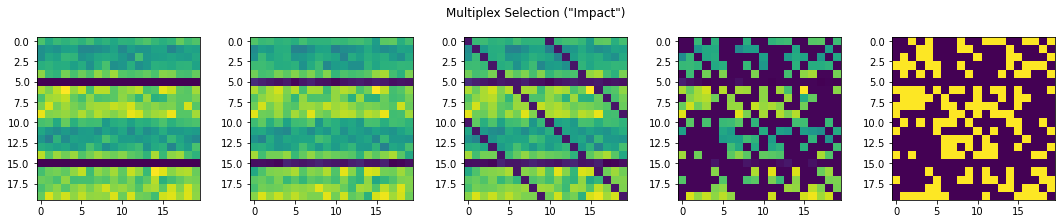

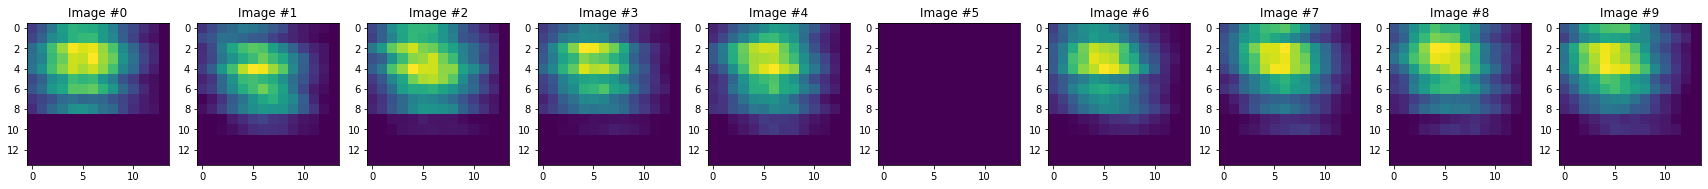

In [17]:
tmp = do_round(images, True)

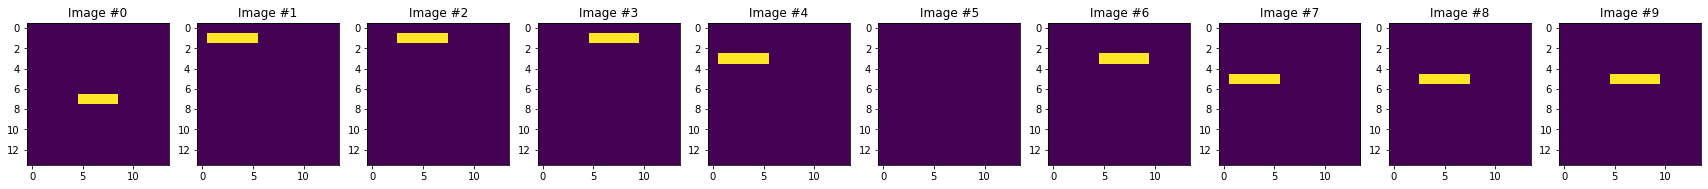

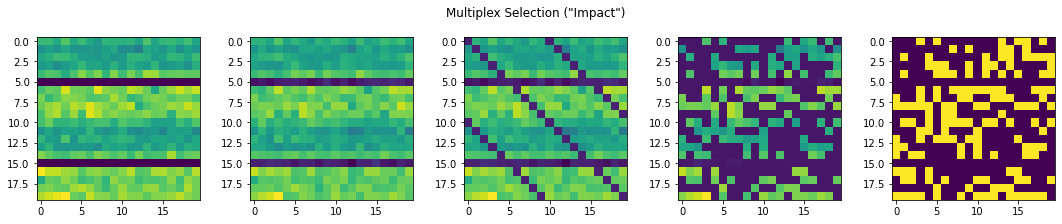

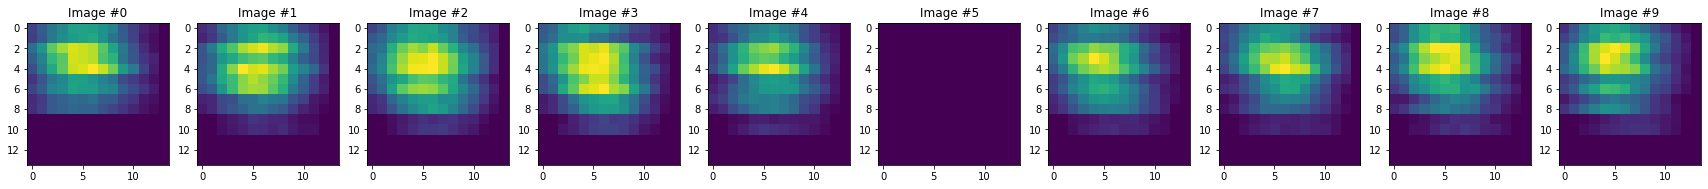

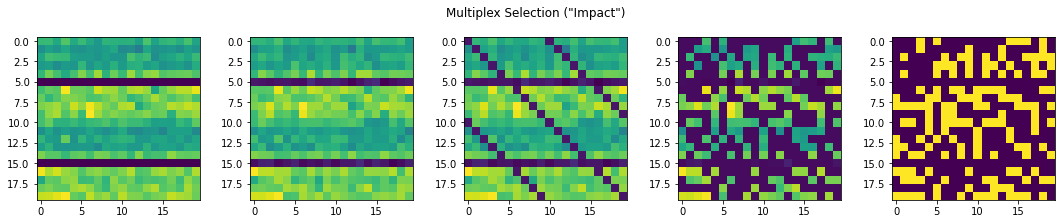

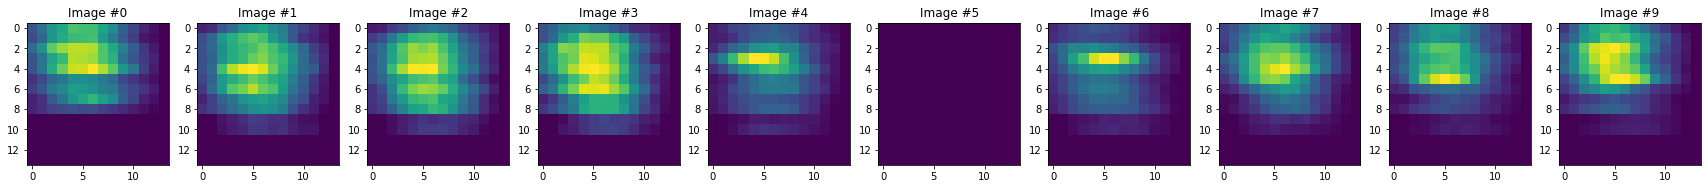

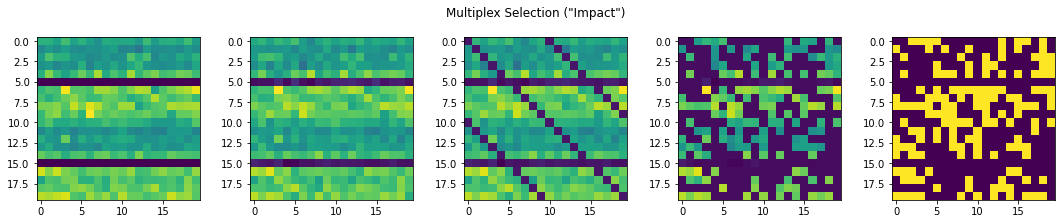

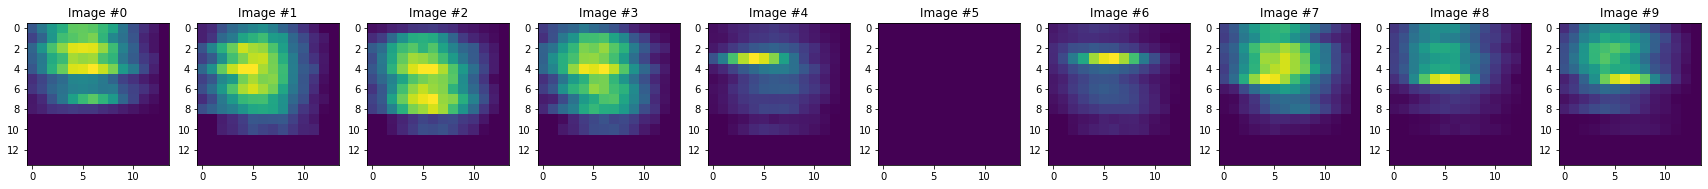

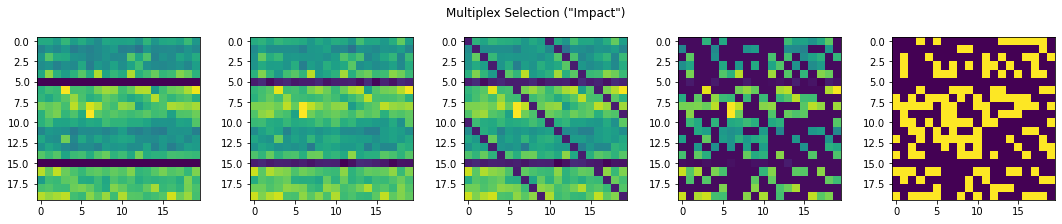

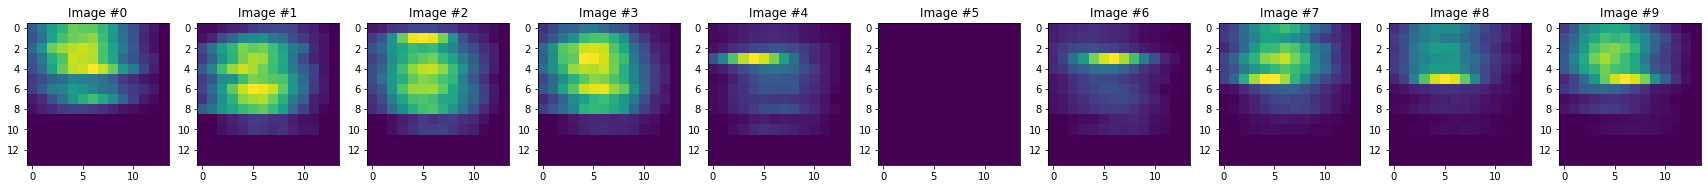

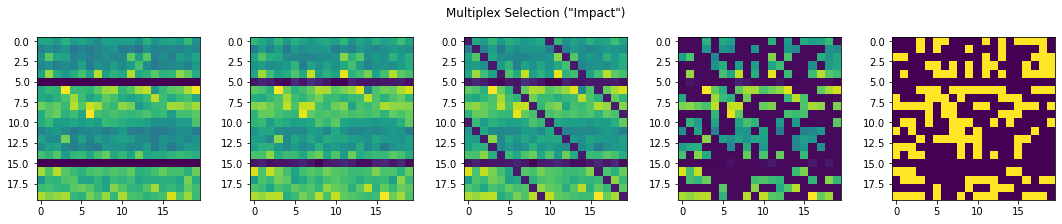

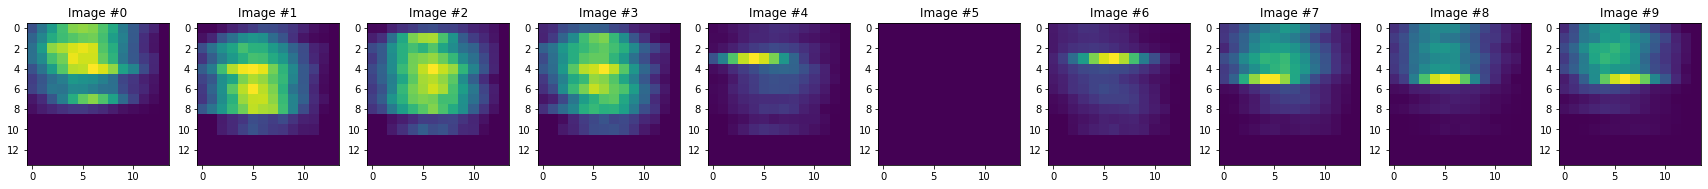

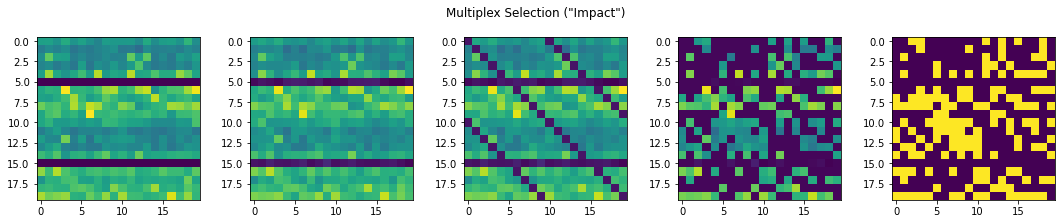

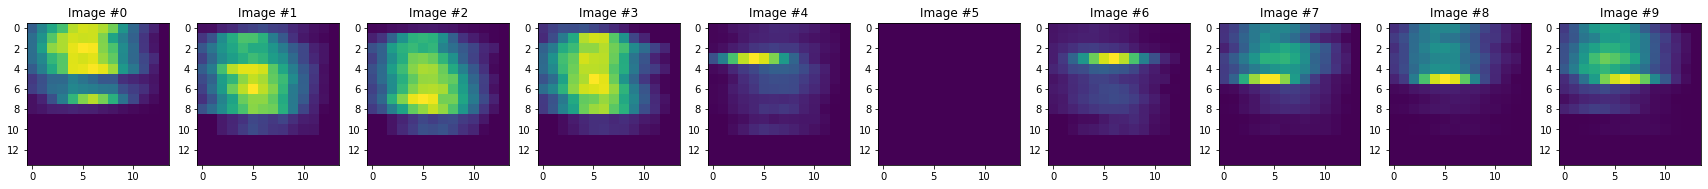

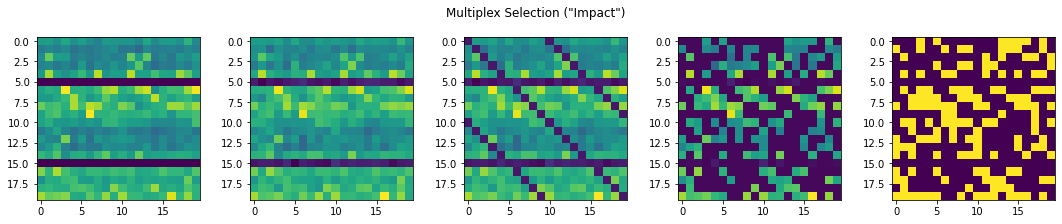

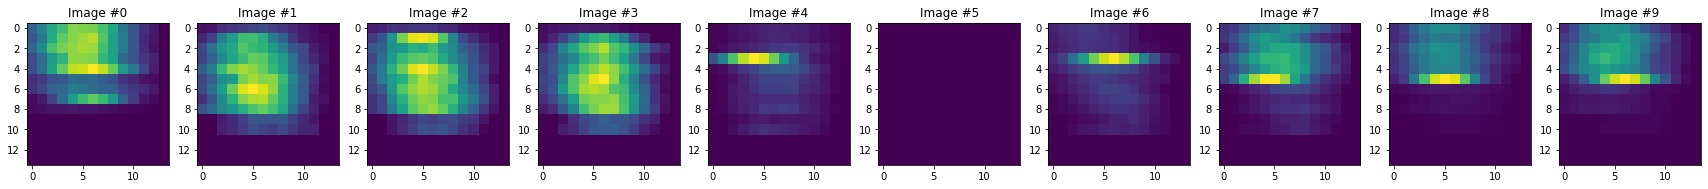

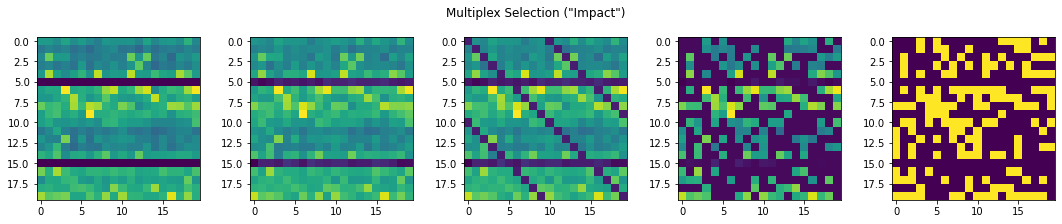

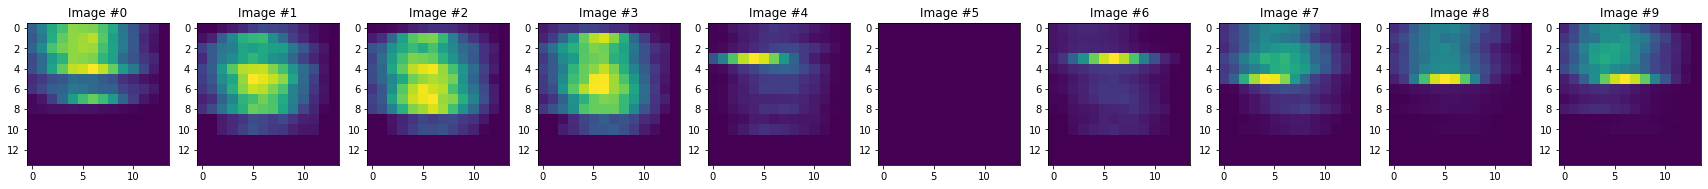

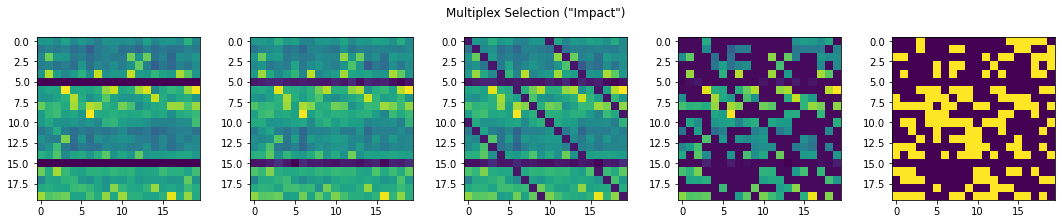

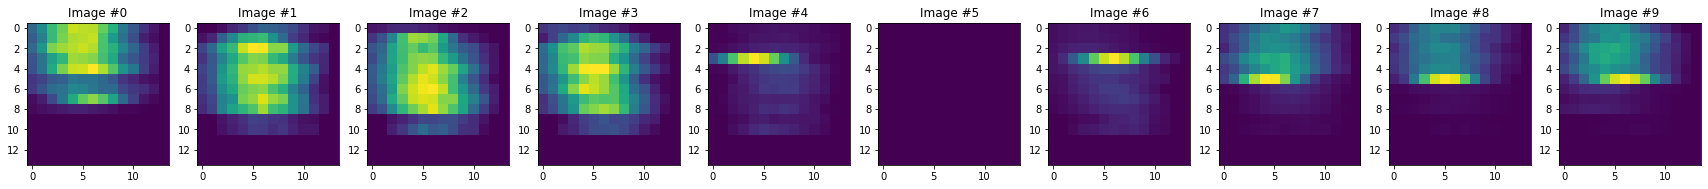

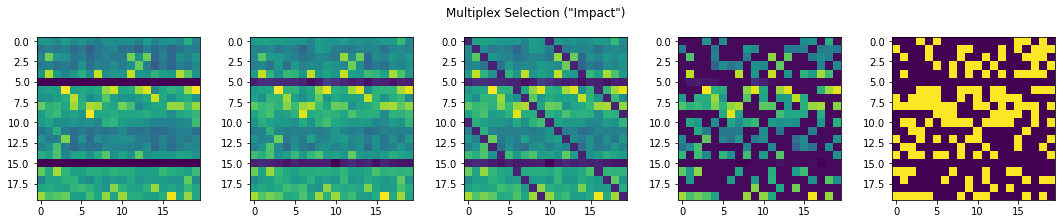

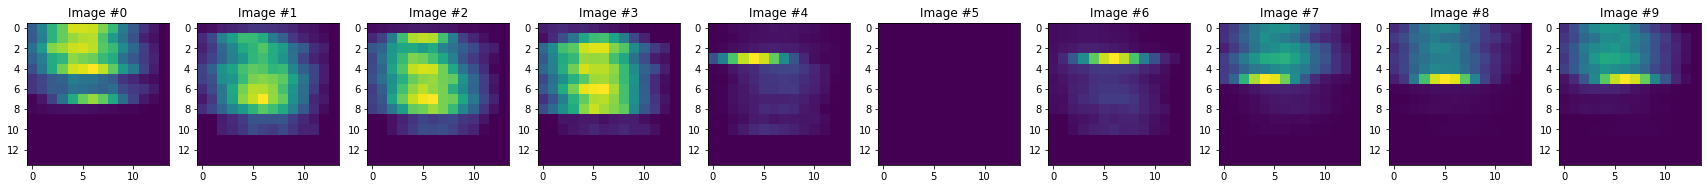

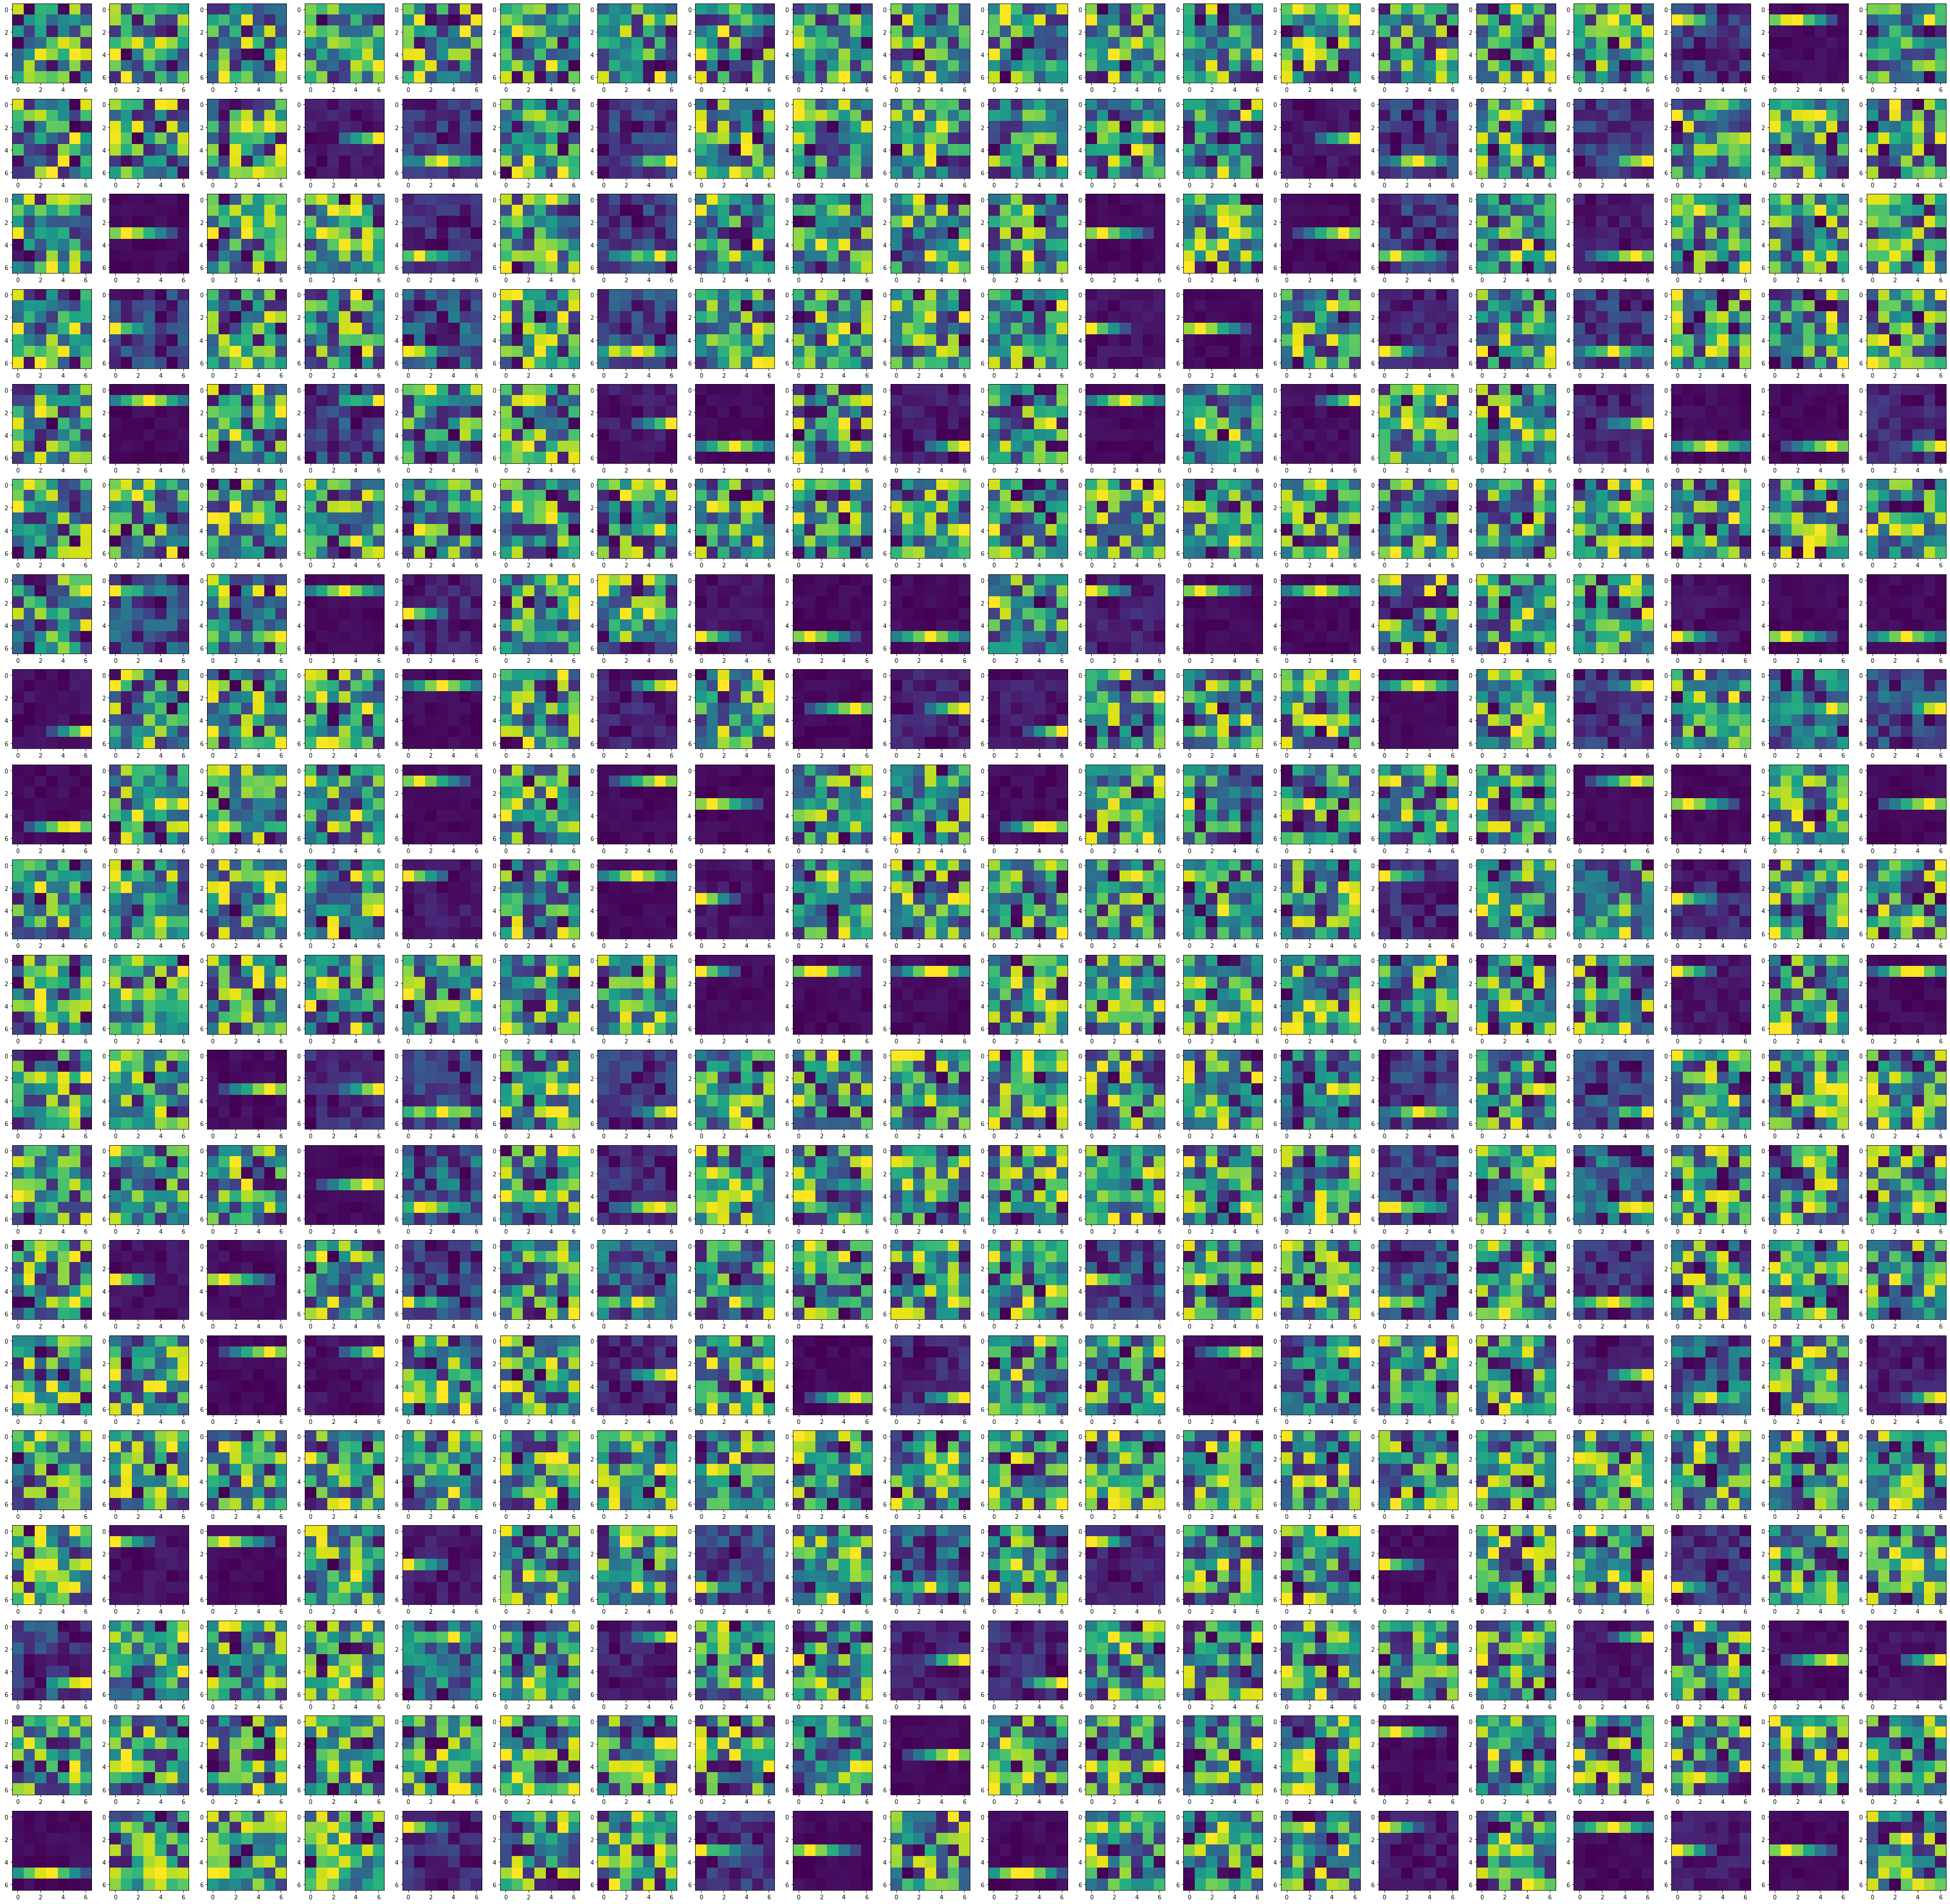

In [7]:
plot_images(images)
for _ in range(10):
    tmp = do_round(images)
plot_kernels(lcl.K)

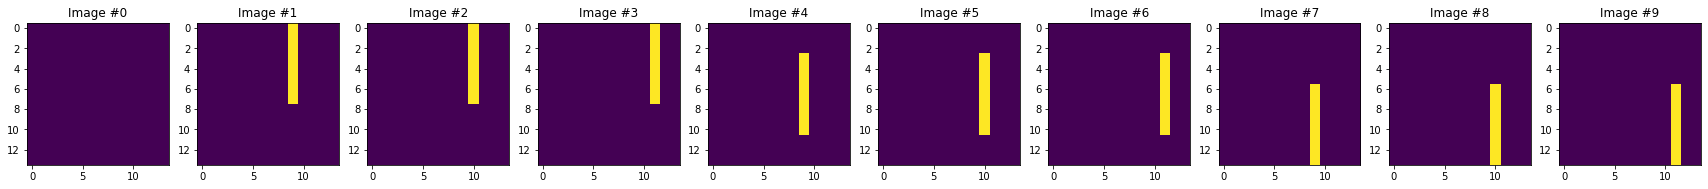

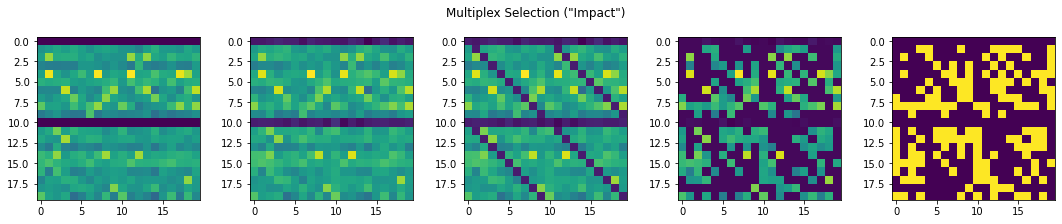

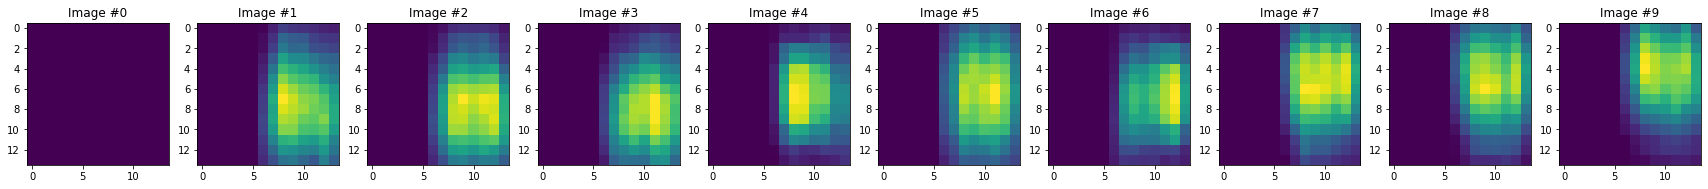

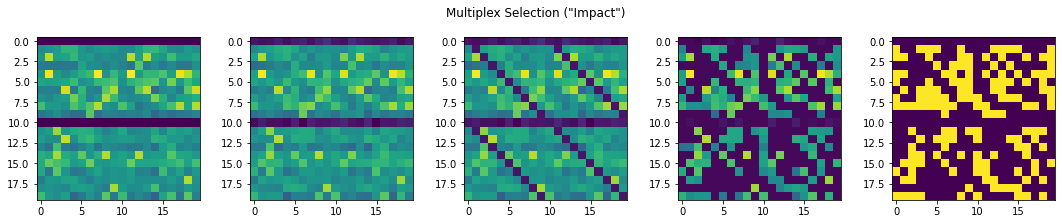

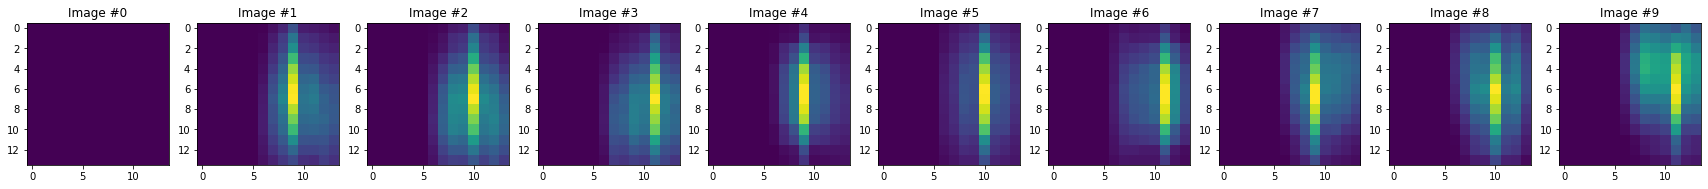

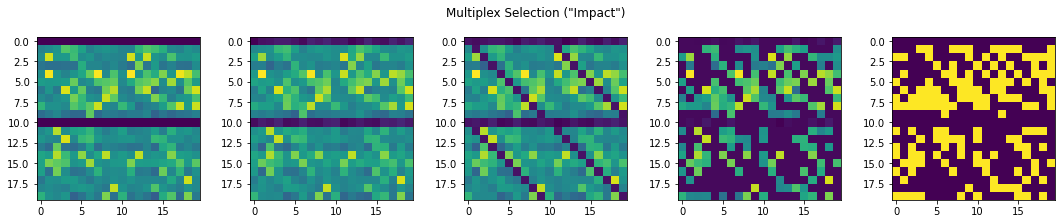

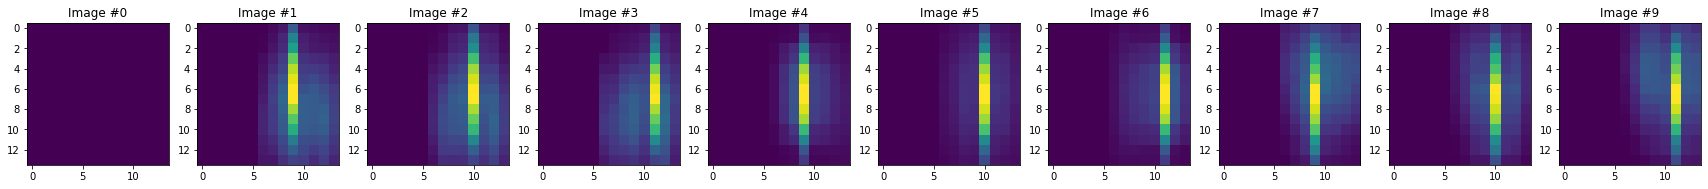

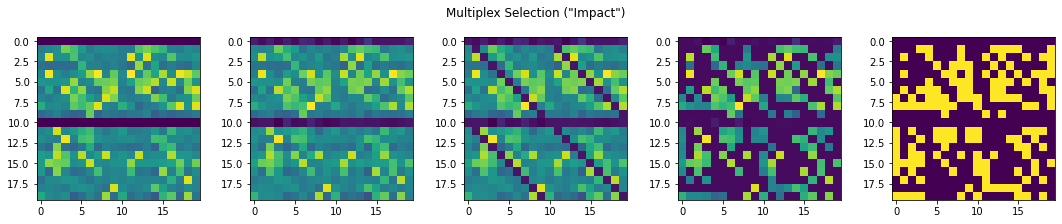

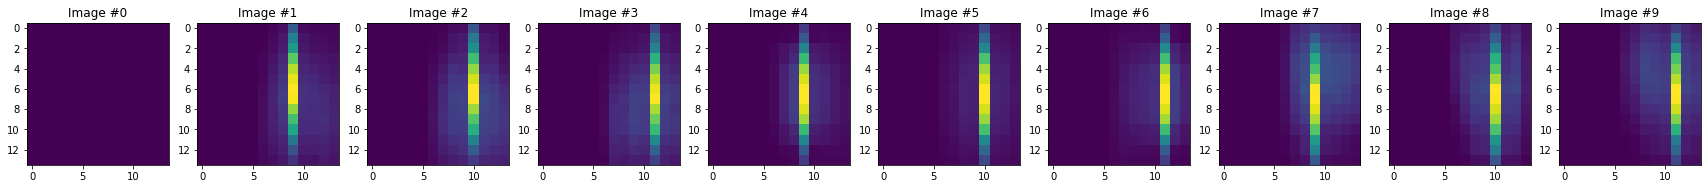

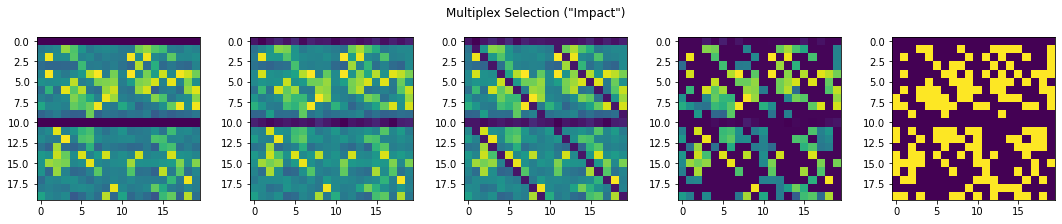

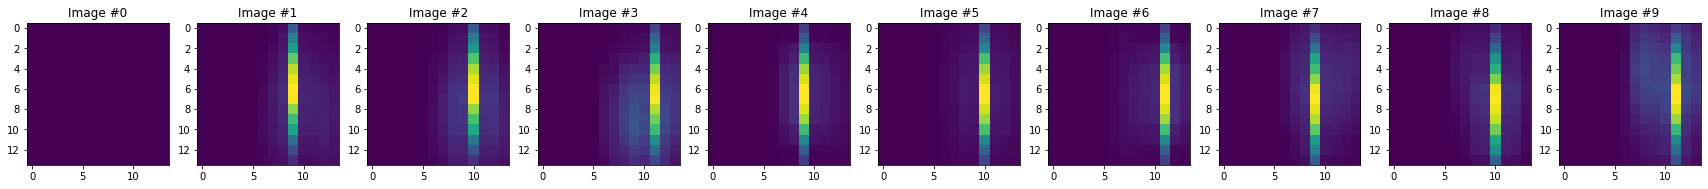

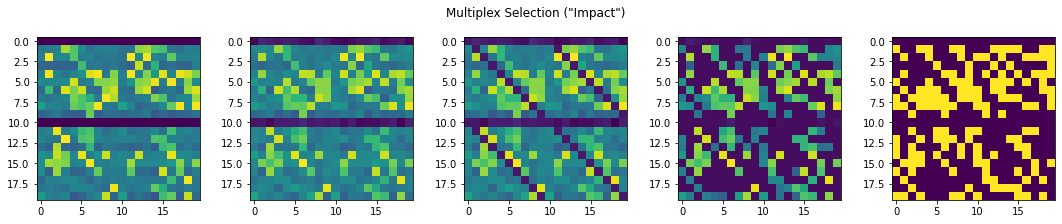

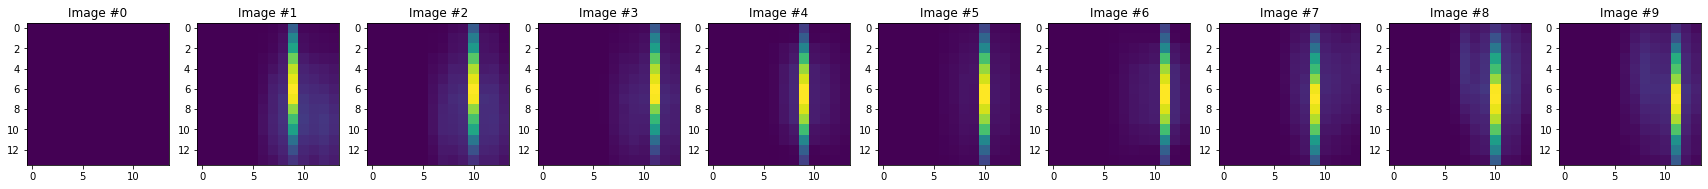

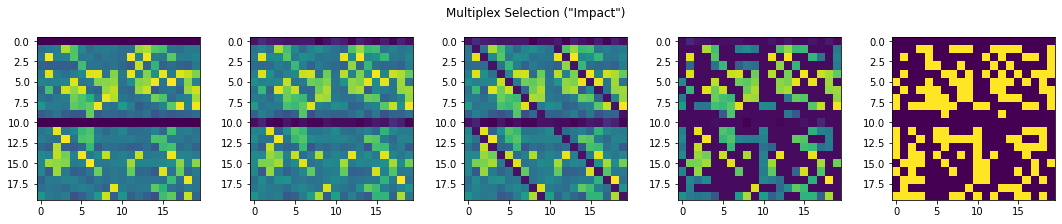

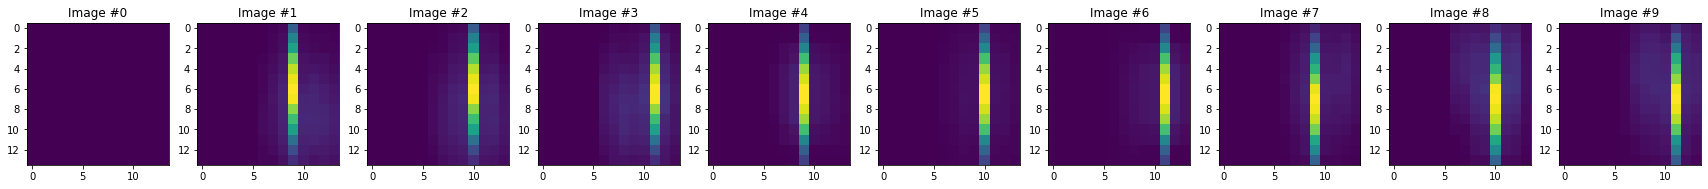

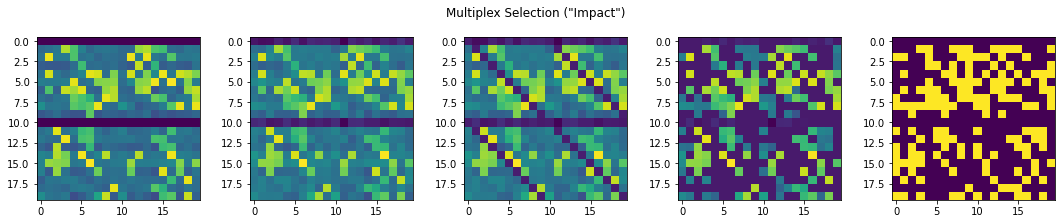

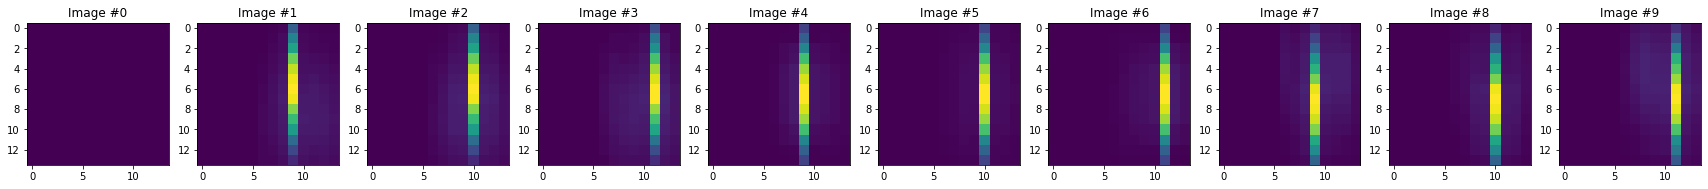

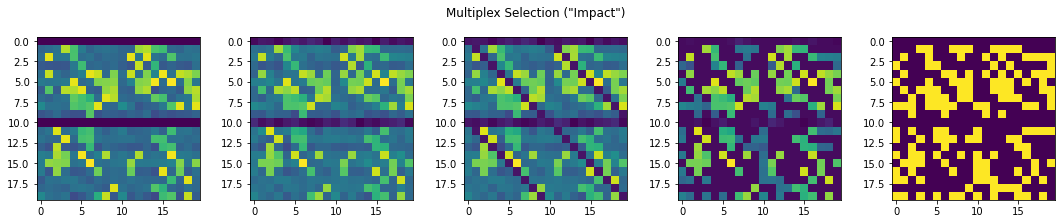

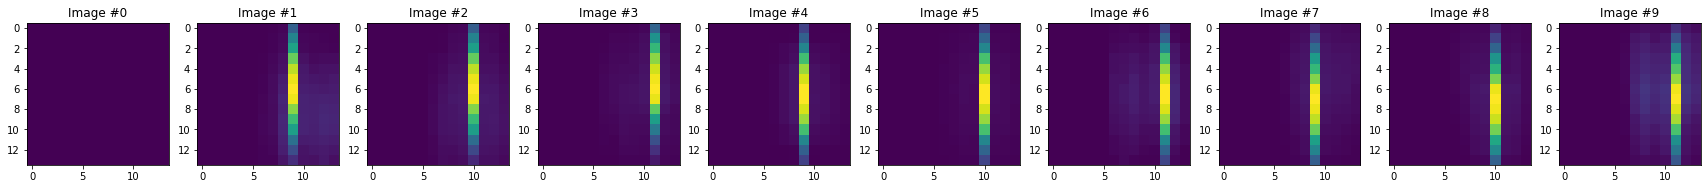

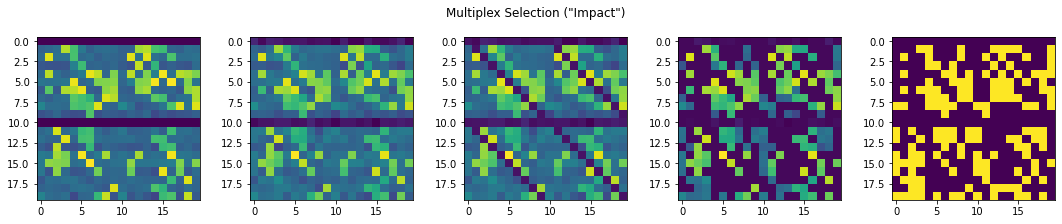

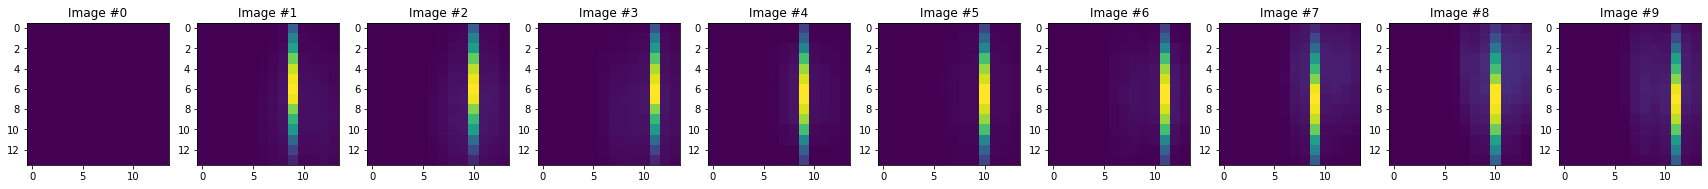

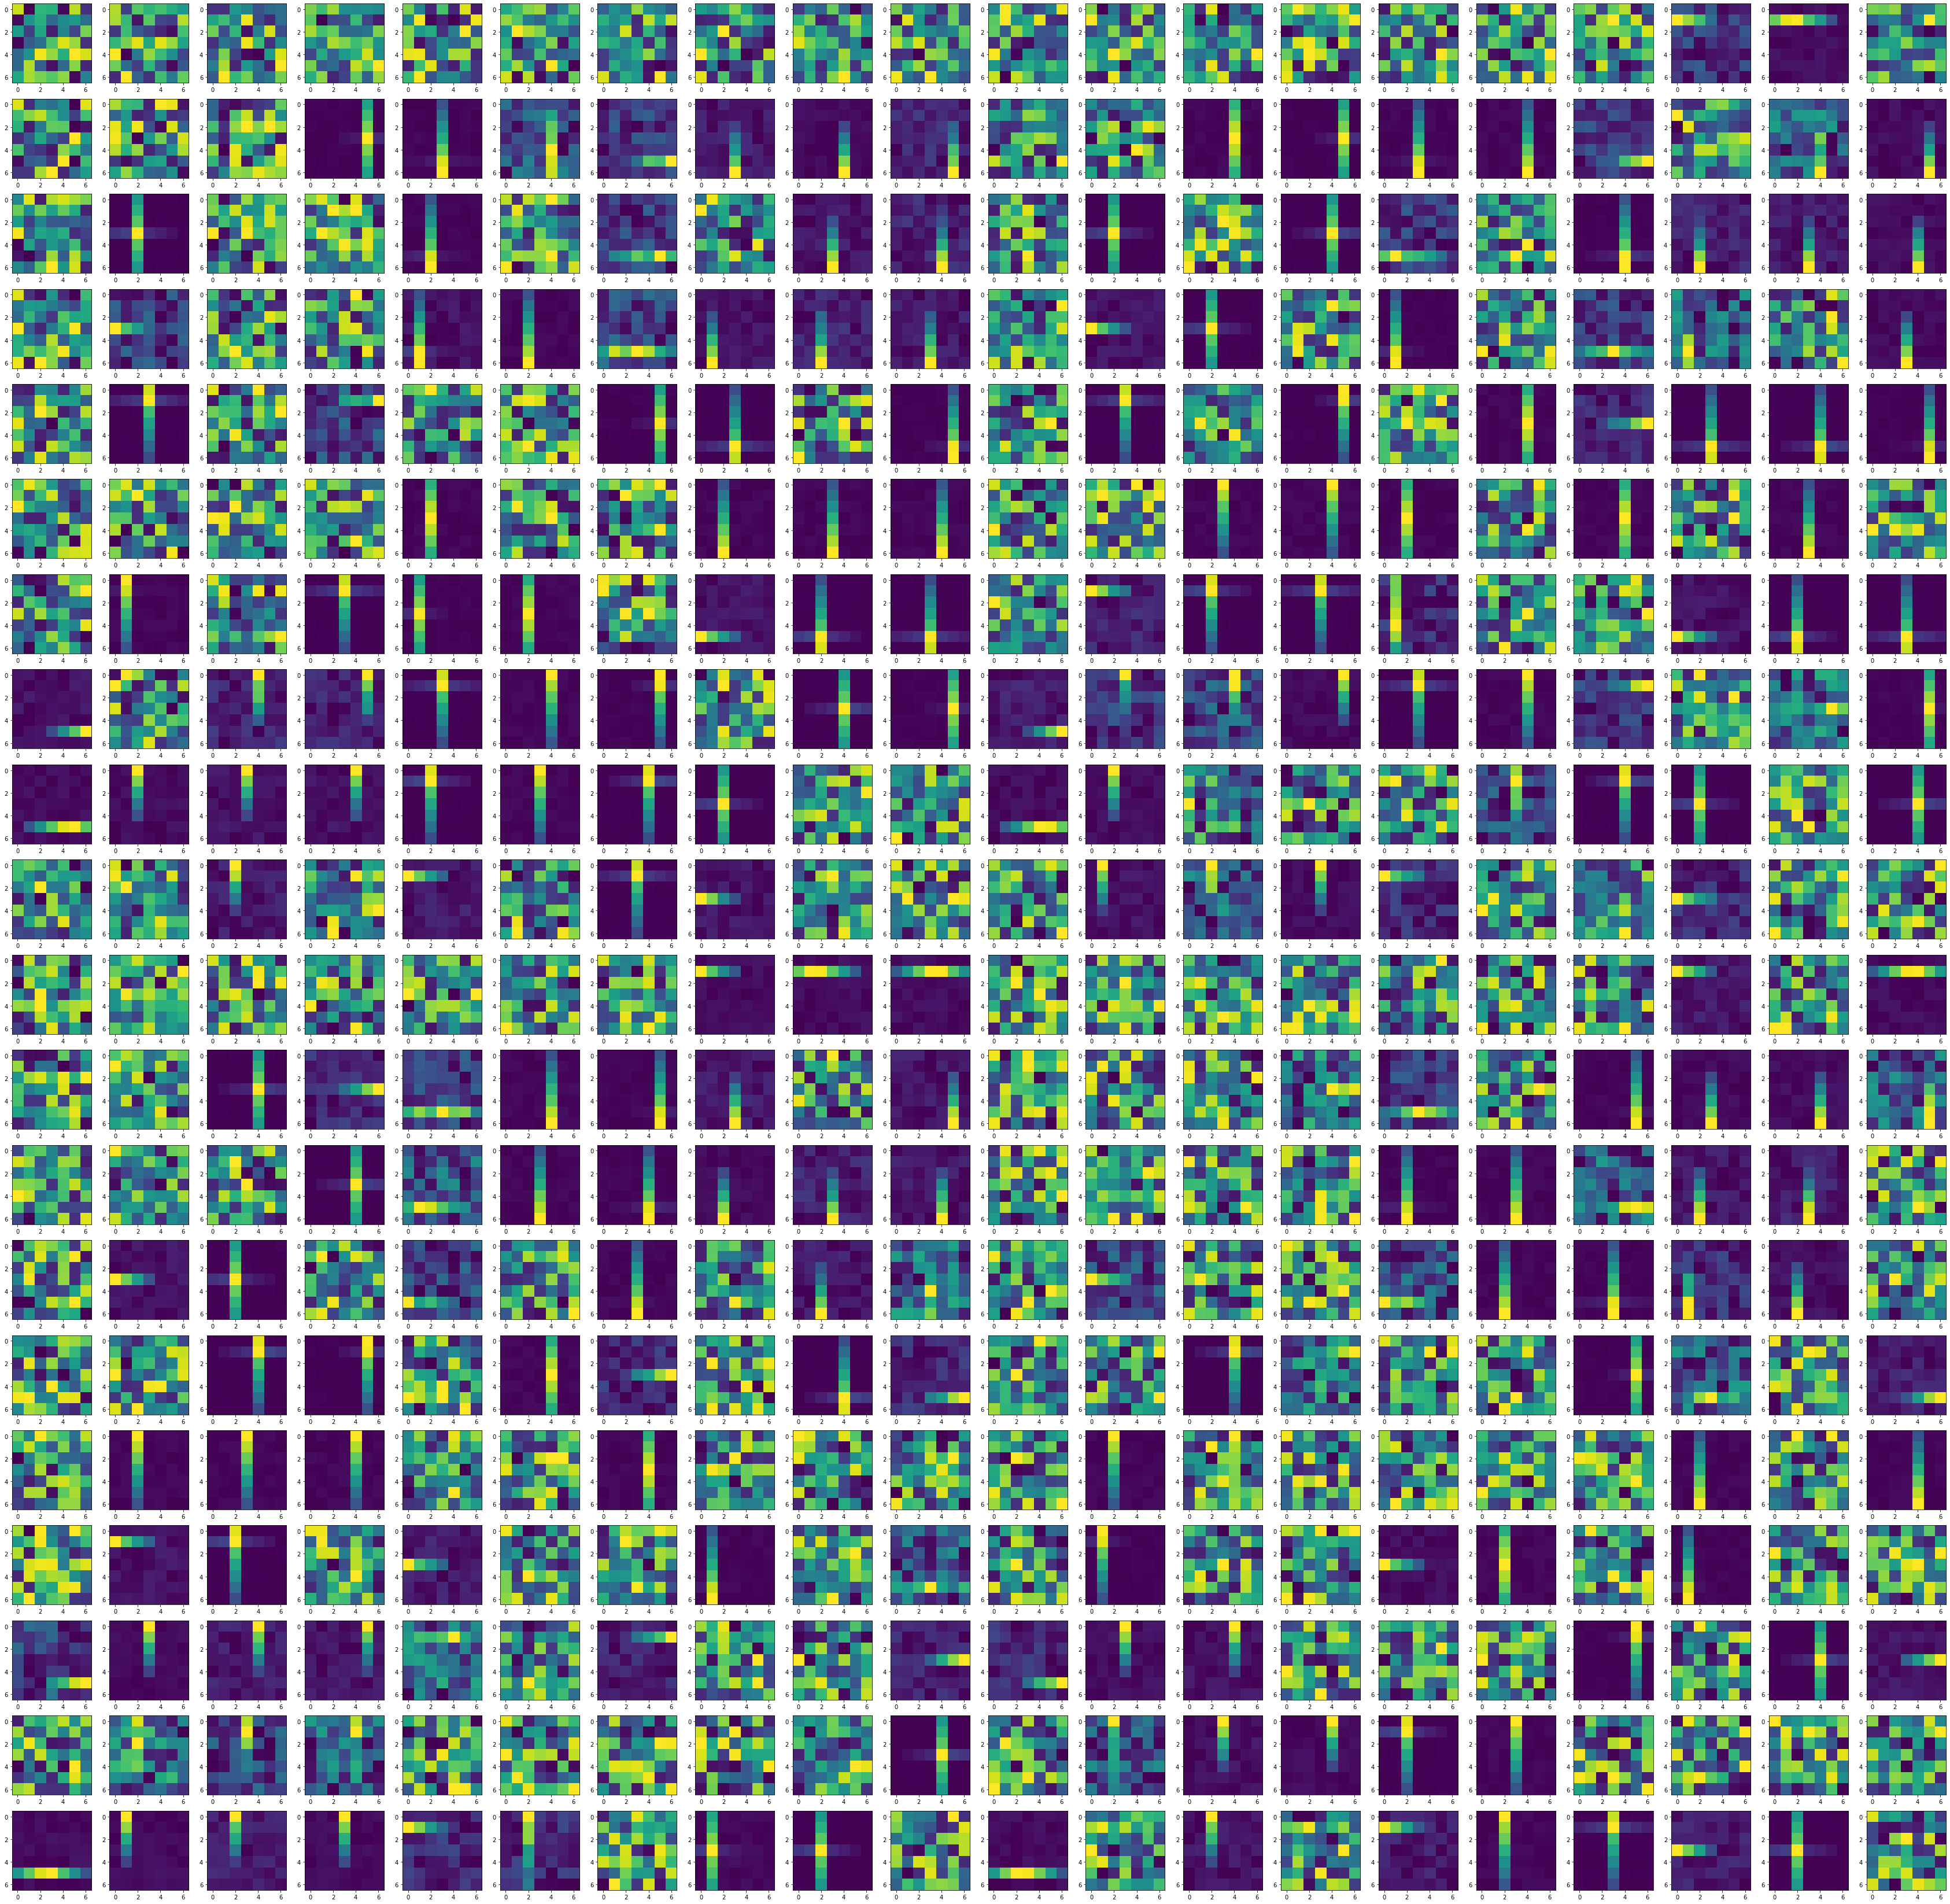

In [8]:
plot_images(images2)
for _ in range(10):
    tmp = do_round(images2)
plot_kernels(lcl.K)

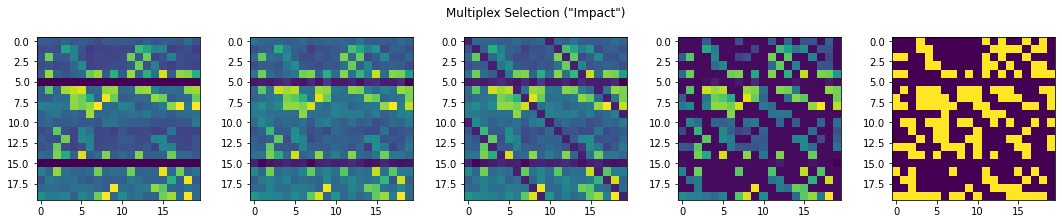

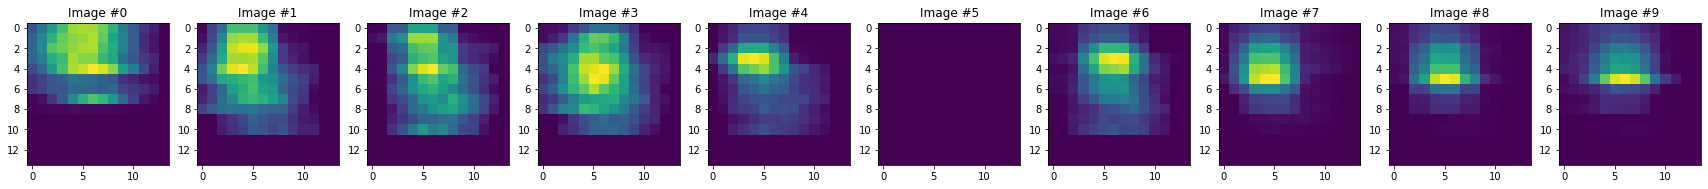

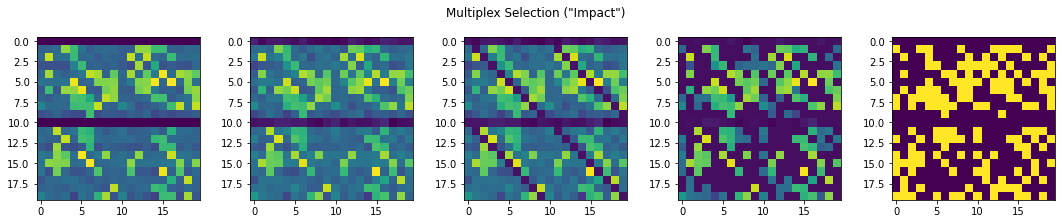

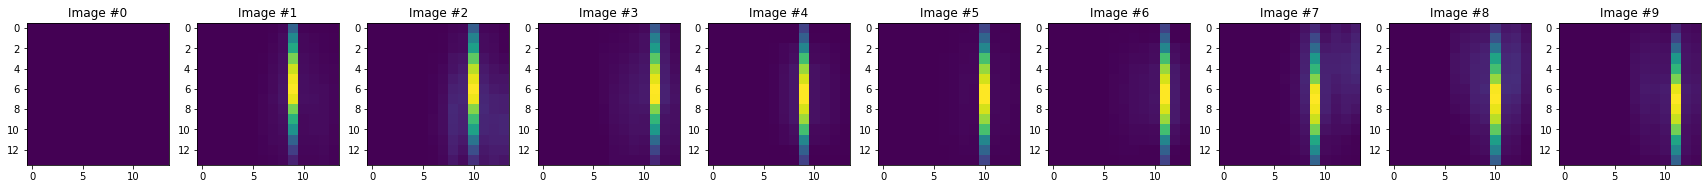

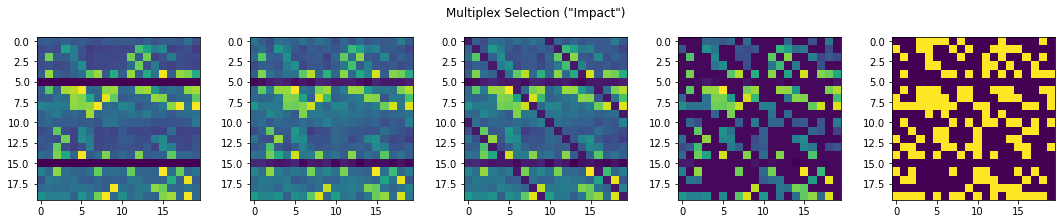

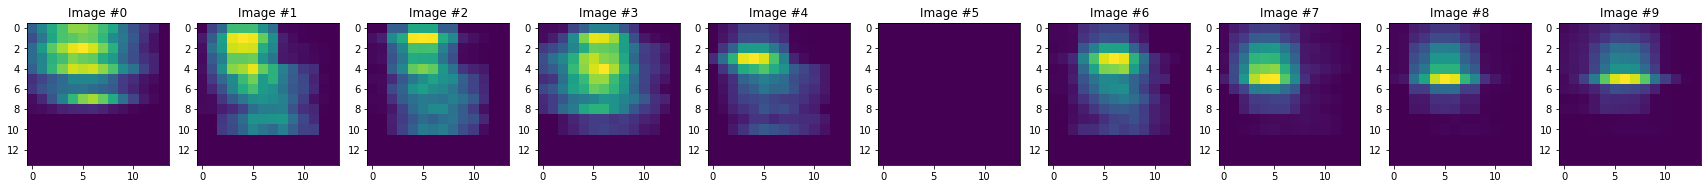

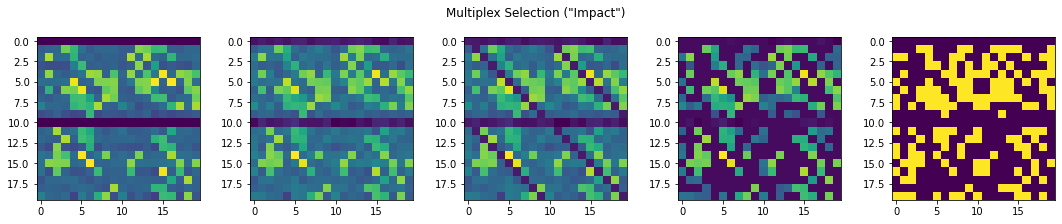

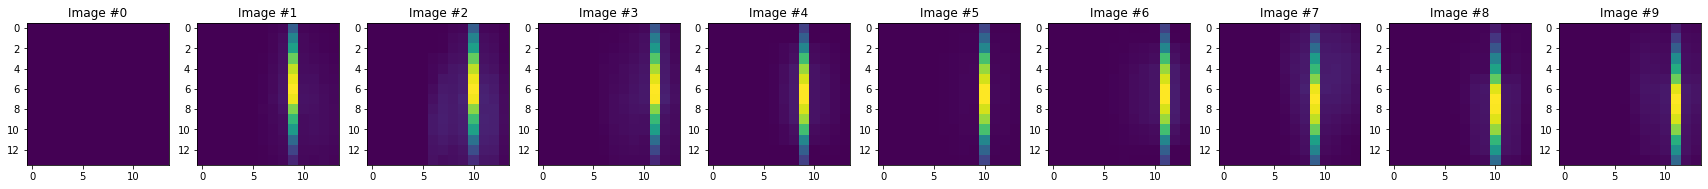

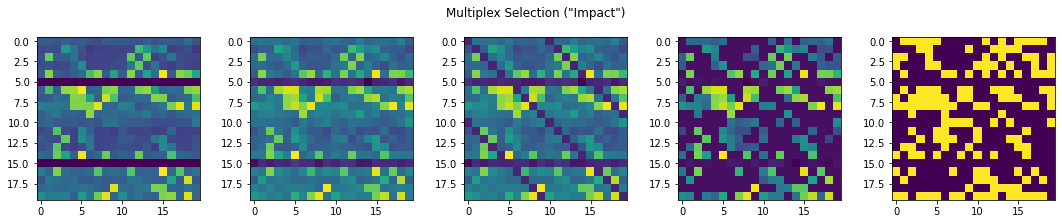

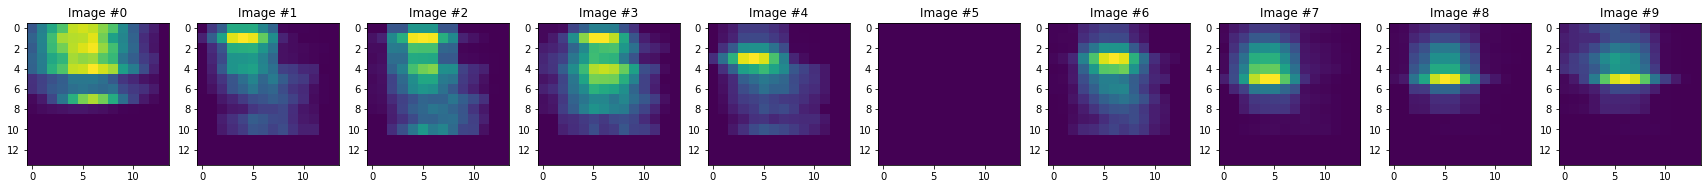

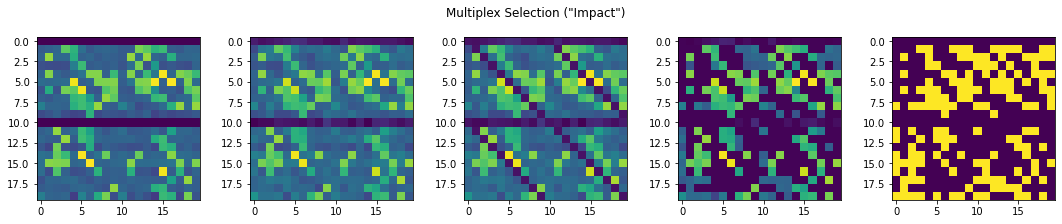

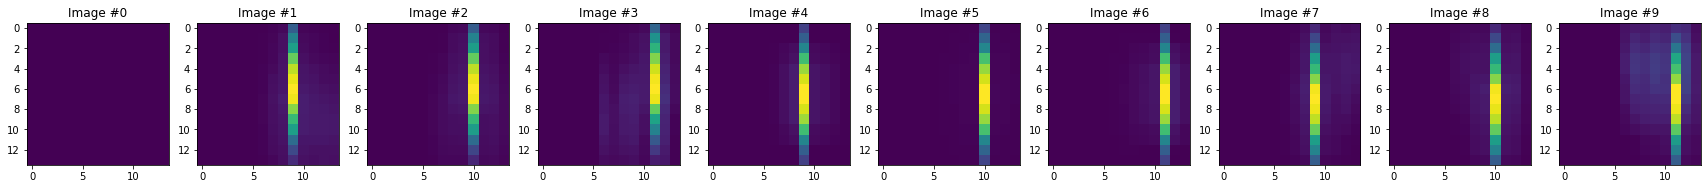

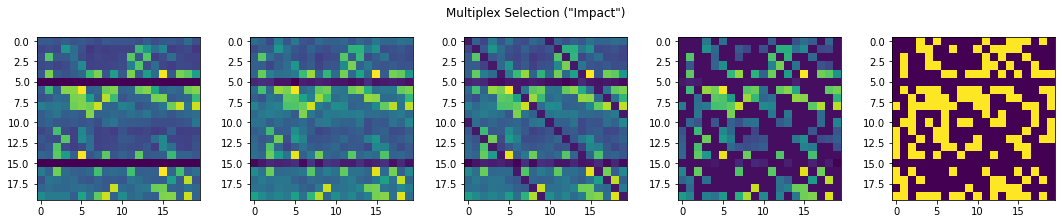

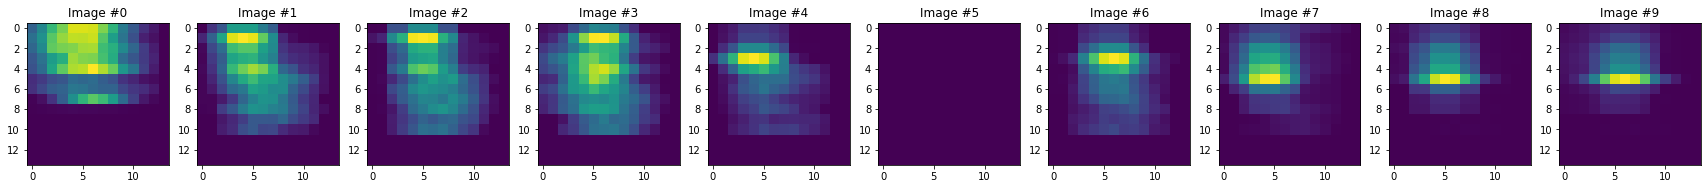

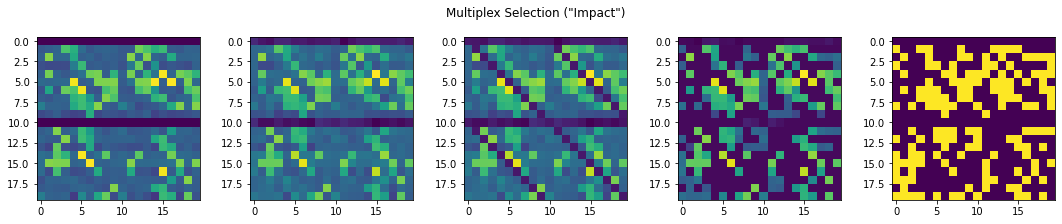

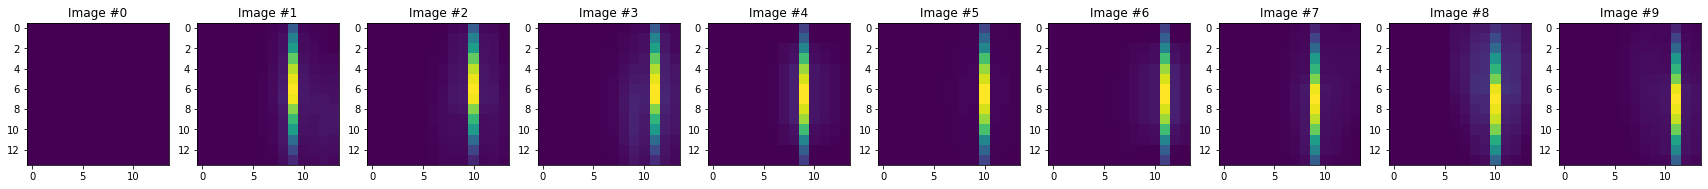

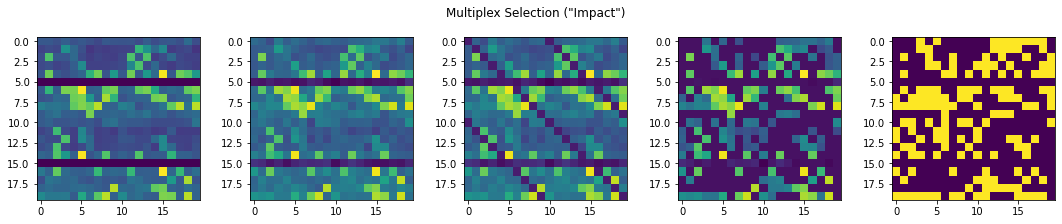

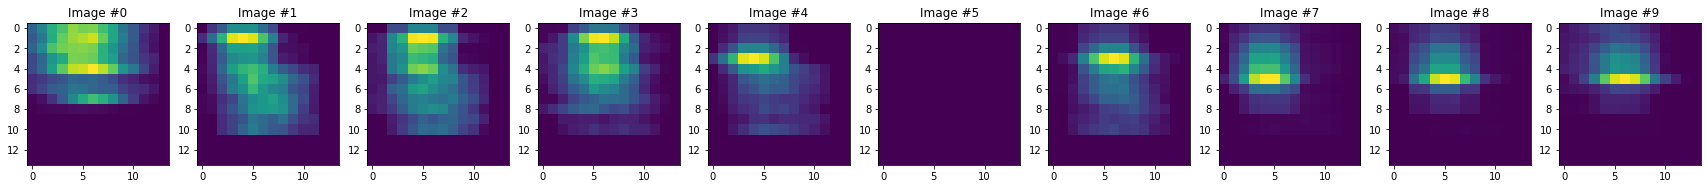

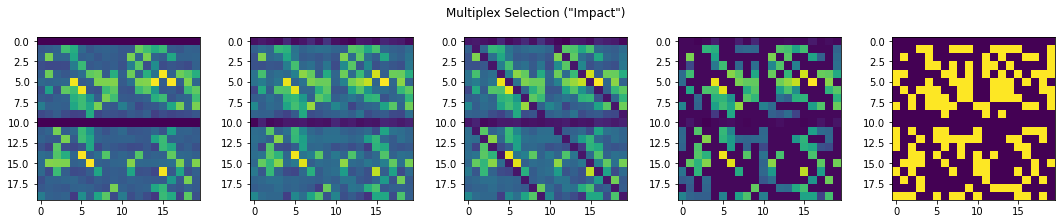

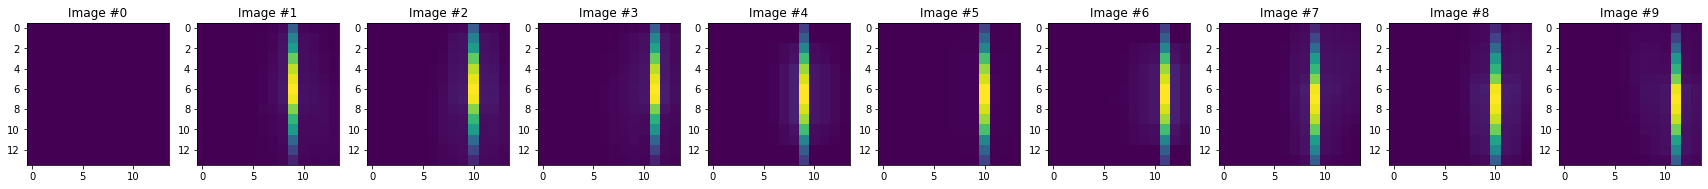

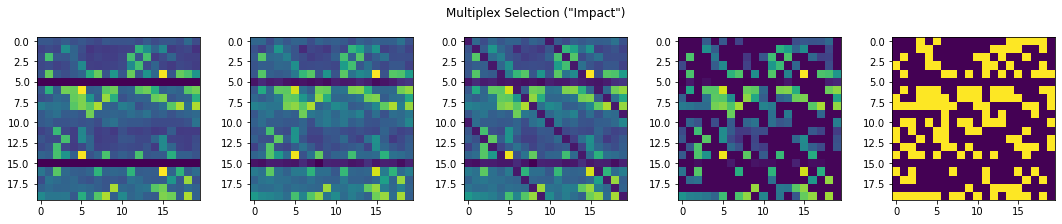

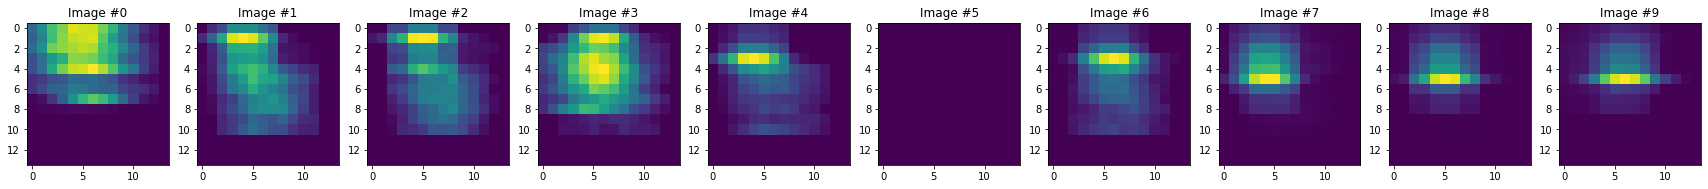

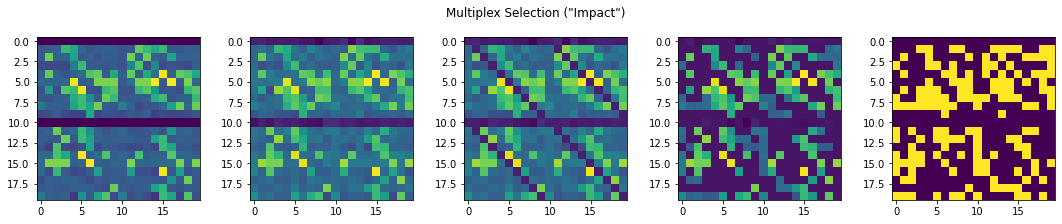

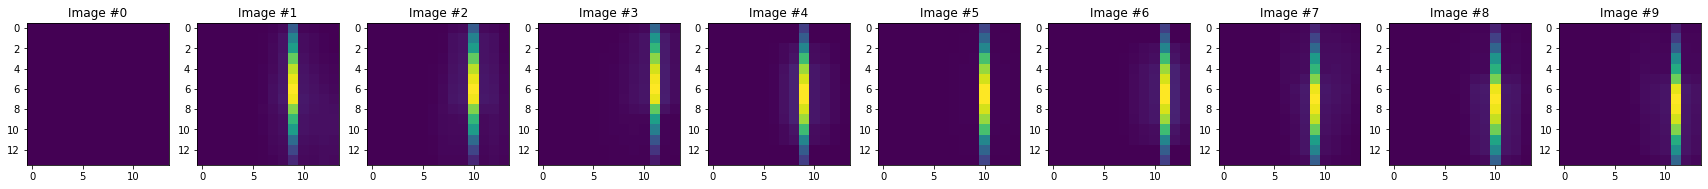

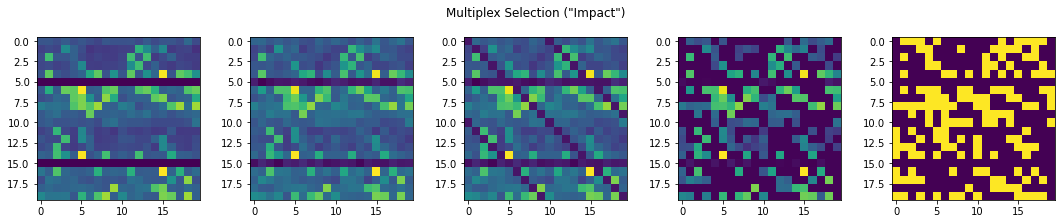

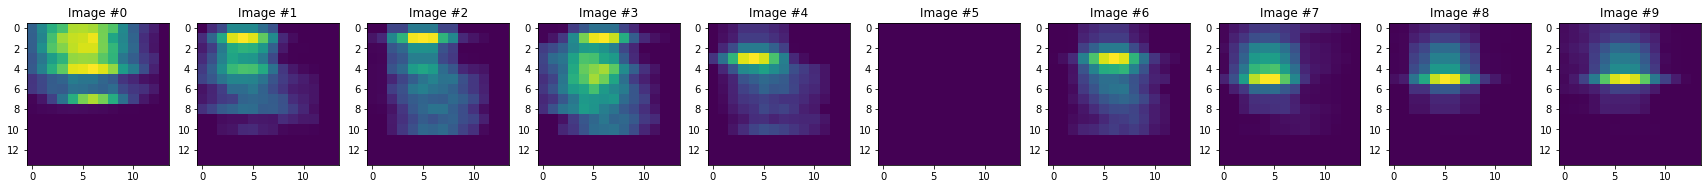

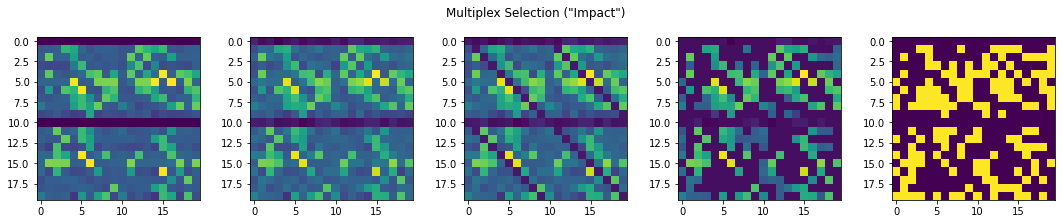

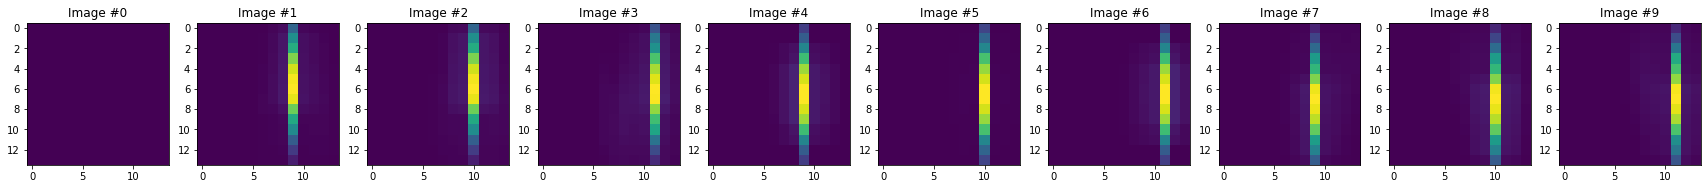

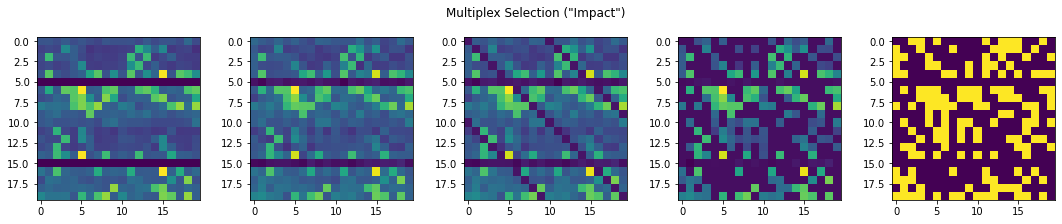

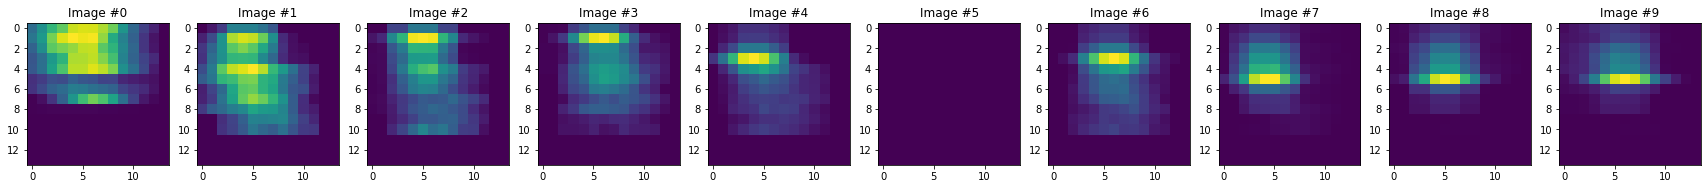

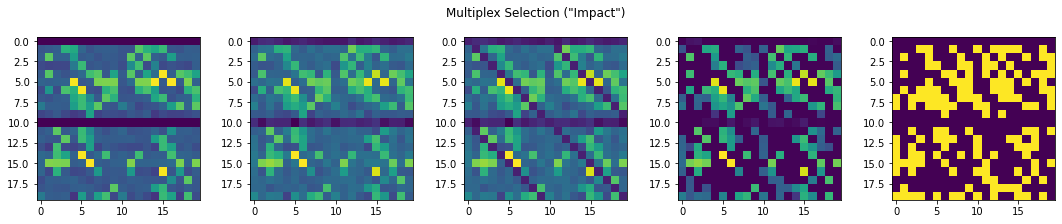

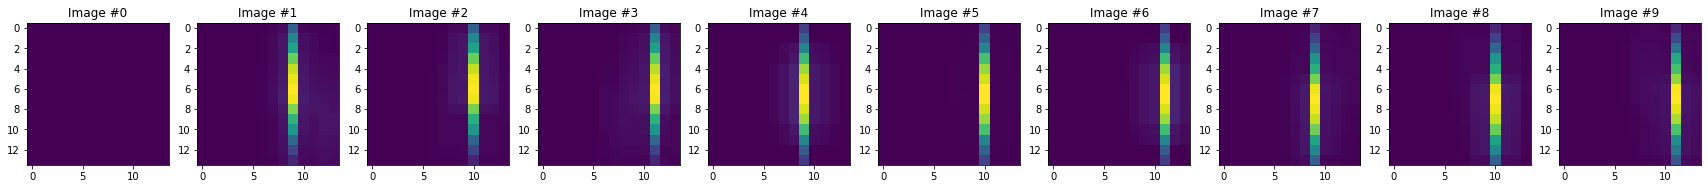

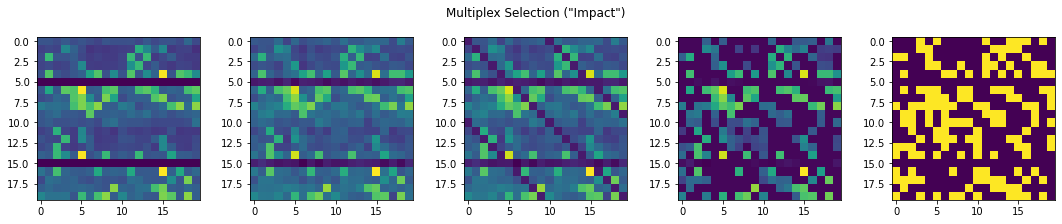

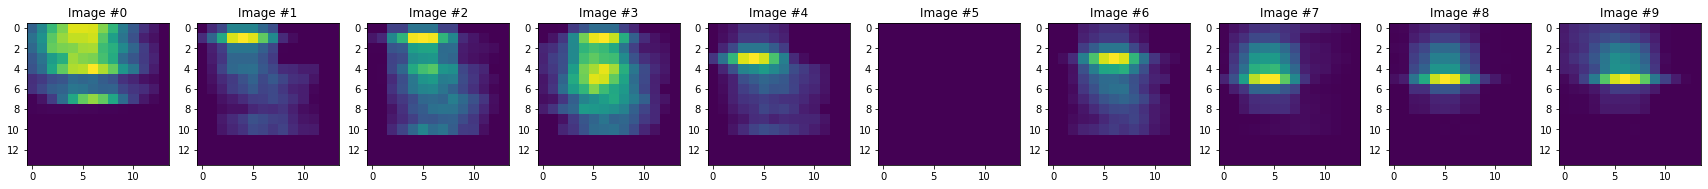

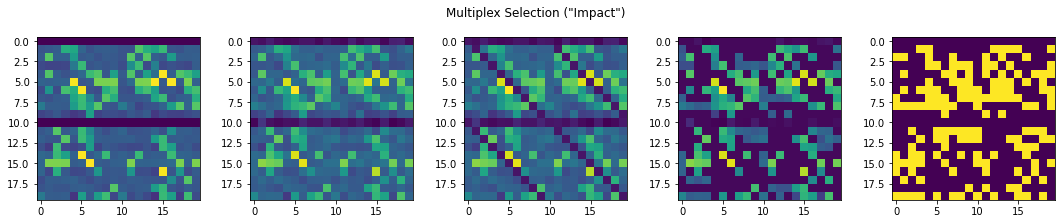

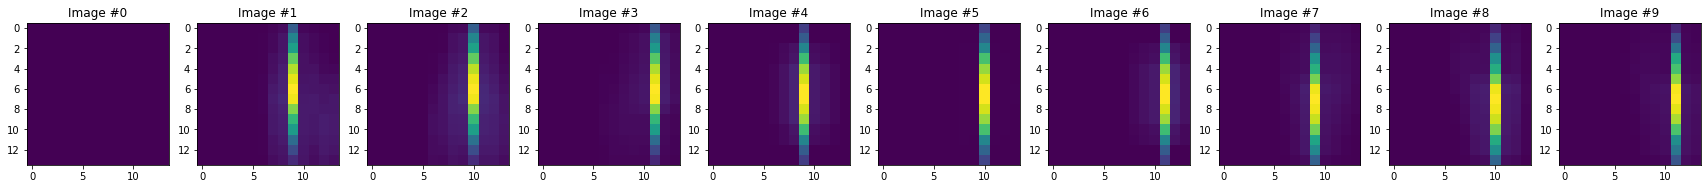

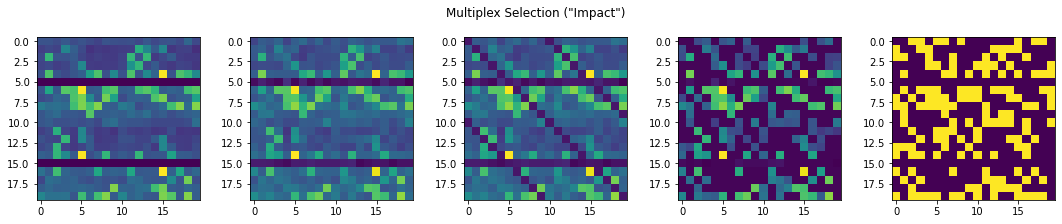

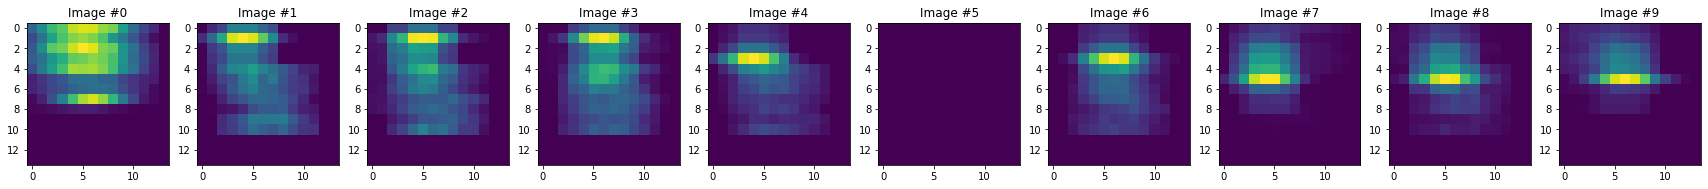

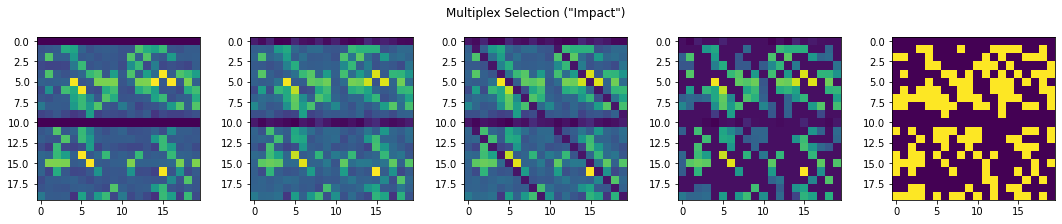

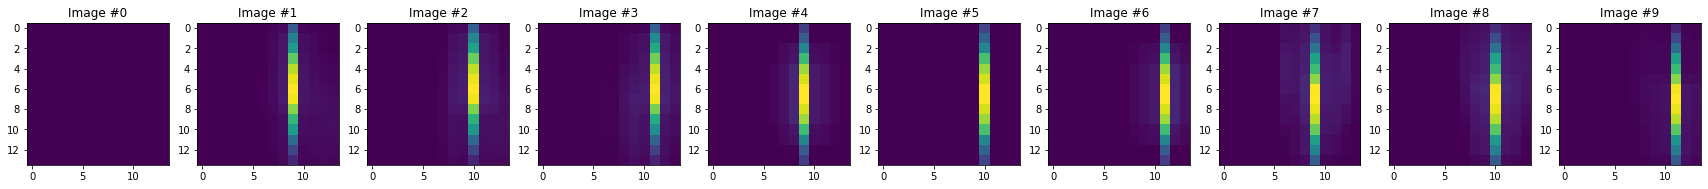

In [9]:
for _ in range(10):
    tmp = do_round(images)
    tmp = do_round(images2)

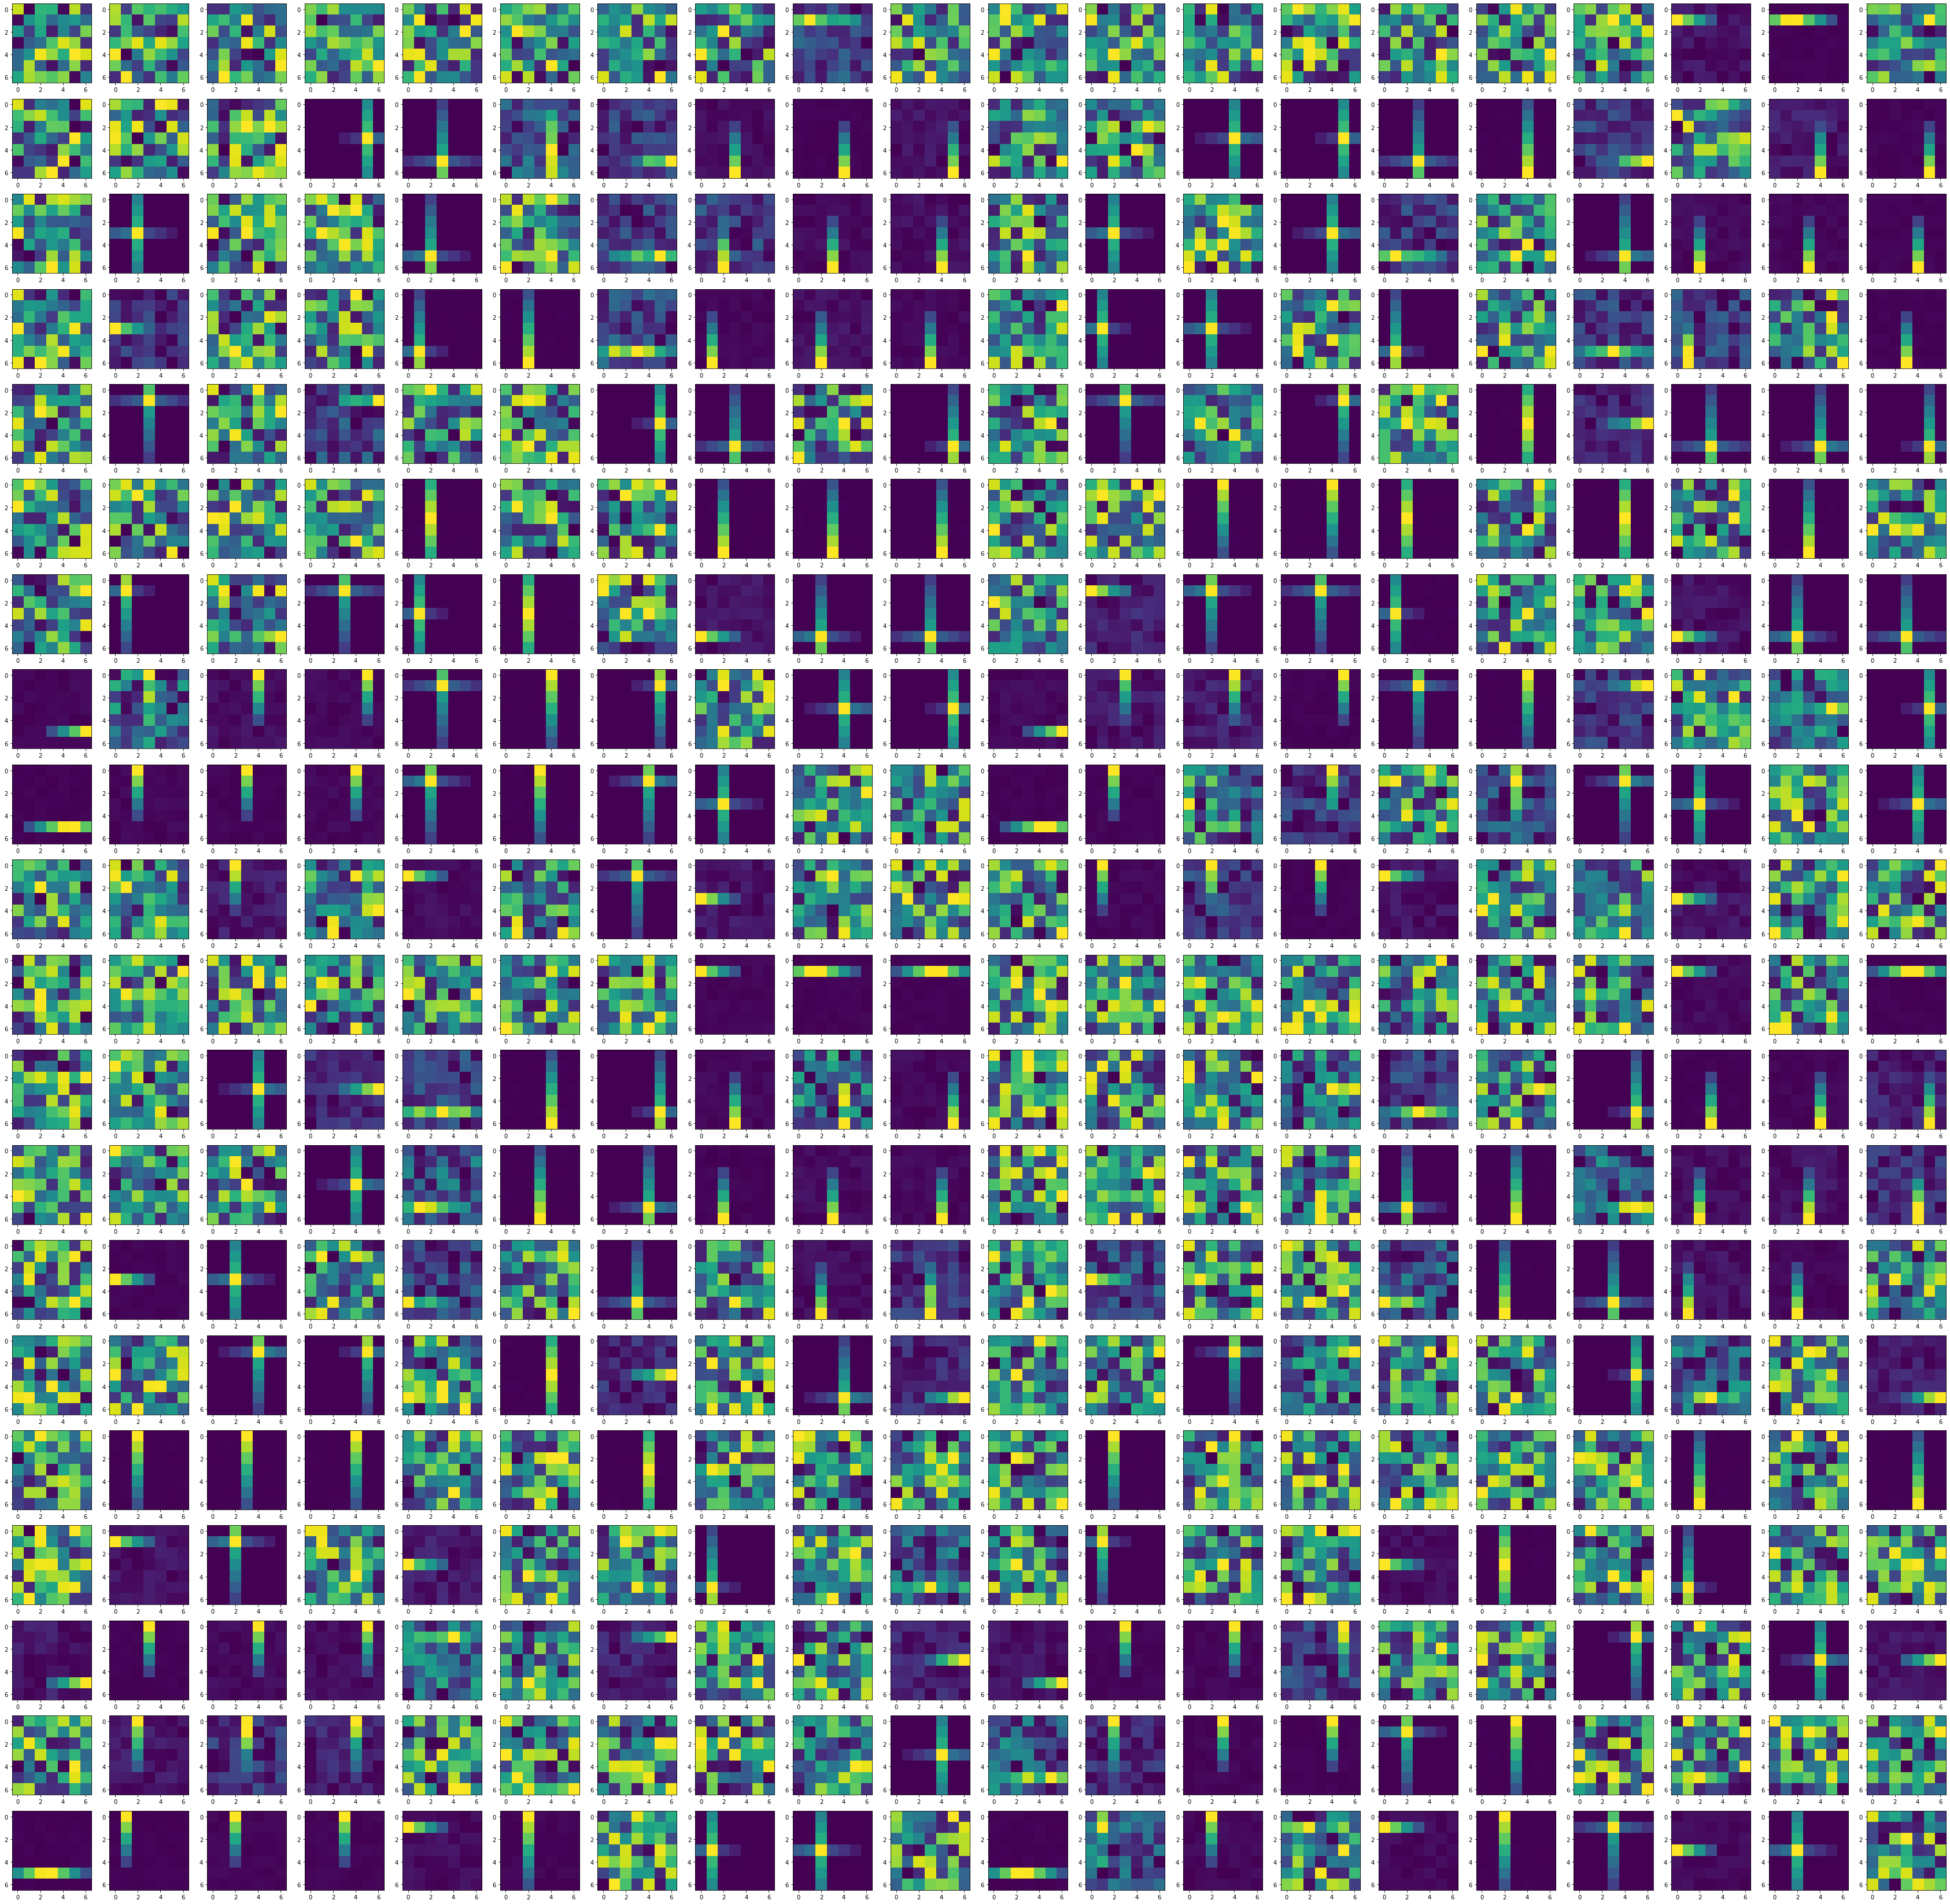

In [10]:
plot_kernels(lcl.K)